# Проект по предсказанию оттока клиентов оператора связи "ТелеДом"

**Описание проекта**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Цель исследования**

Провести анализ данных, а также создать модель которая будет предсказывать клиентов, которые захотят разорвать договор

**Задачи исследования**

Построить модель, которая сможет на основе данных заказчика предсказать то, что абонент захочет отказаться от услуг компании.

**Исходные данные**

1 **contract_new** - содержит информацию о договоре.

2 **personal_new** - содержит персональные данные клиента.

3 **internet_new** - содержит информацию об интернет-услугах.

4 **phone_new** - содержит информацию об услугах телефонии.



**Данное исследование разделим на несколько частей**

***Часть 1. Загрузка данных***

[*Загрузка библиотек*](#section1)

[*Загрузка данных*](#section2)

***Часть 2. Предобработка данных***

[*Изучение файла contract_new*](#section3)

[*Изучение файла personal_new*](#section4)

[*Изучение файла internet_new*](#section5)

[*Изучение файла phone_new*](#section6)

[*Вывод по Предобработке данных*](#section7)

***Часть 3. Объединение данных***

[*Объединение файлов*](#section8)

[*Выводы по объединению файлов*](#section9)

***Часть 4. Исследовательский анализ данных***

[*Анализ категориальных столбцов*](#section10)

[*Анализ количественных столбцов*](#section11)

[*Анализ портрета отключенных абонентов*](#section12)

[*Анализ тенденции на приток и отток клиентов*](#section13)

[*Корреляционный анализ признаков*](#section14)

[*Выводы по исследовательскому анализу данных*](#section15)

***Часть 5. Подготовка данных и обучение моделей***

[*Разделение данных на обучающую и тестовую выборку*](#section16)

[*Создание пайплайна и модели для Логистической регрессии*](#section17)

[*Создание пайплайна и модели для Дерева Решении*](#section18)

[*Обучение модели Случайного леса*](#section19)

[*Обучение модели CatBoostClassifier*](#section20)

[*Обучение константной модели*](#section21)

[*Вывод по обучениям моделей*](#section22)

***Часть 6. Тестирование лучшей модели на тестовых данных***

[*Надстройка модели CatBoost*](#section28)

[*Тестирование лучшей модели*](#section23)

[*Тестирование константной модели*](#section24)

***Часть 7. Анализ важности признаков***

[*Анализ признаков методом SHAP*](#section25)

[*построение матрицы ошибок*](#section26)

[*Вывод по анализам важности признаков*](#section27)

***Общий вывод по проекту***


## Часть 1. Загрузка данных

<a id='section1'></a> 
### Загрузка библиотек

Установи нужные библиотеки и константы

In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip install -q skimpy
!pip install -q phik
!pip install -q shap 
!pip install -U scikit-learn -q
!pip install -q catboost

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from skimpy import clean_columns
from phik.report import correlation_report, plot_correlation_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, f1_score
from sklearn.dummy import DummyClassifier
import shap

shap.initjs()

RANDOM_STATE=22072024
TEST_SIZE = 0.25

Делаем визуальные настройки

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

<a id='section2'></a> 
### Загрузка данных

Импортируем файлы

In [4]:
contract_new = pd.read_csv('/datasets/contract_new.csv')
personal_new = pd.read_csv('/datasets/personal_new.csv')
internet_new = pd.read_csv('/datasets/internet_new.csv')
phone_new = pd.read_csv('/datasets/phone_new.csv')

## Часть 2. Предобработка данных

<a id='section3'></a> 
### Изучение файла contract_new

Разберем файл **contract_new**. Начнем с вывода общей информации

In [5]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Столбец **customerID** должен быть уникальным идентификатором клиента. Проверим что там нет дублей

In [7]:
contract_new['customerID'].nunique()

7043

Дублей нет, как и пропусков в данных. Можно заметить, что столбцы не в "питоновском" регистре и тип данных не соответствует данным в них. Будем это исправлять

Нужно привести столбцы к питоновскому регистру

In [8]:
contract_new = clean_columns(contract_new)

Заодно установим наш ID как индекс, чтобы было проще объеденять данные, а также, чтобы столбец не мешал при работе моделей, так как данный столбец не несет важной информации и не является признаком для модели

In [9]:
contract_new = contract_new.set_index('customer_id')
contract_new.columns

Index(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges'],
      dtype='object')

Создадим столбец который будет показывать действует контракт или нет. Для этого нам поможет столбец с данными end_date.

In [10]:
contract_new['end_date'].sort_values().unique()

array(['2014-06-01', '2014-09-01', '2014-10-01', '2014-11-01',
       '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
       '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
       '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
       '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
       '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
       '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
       '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
       '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
       '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
       '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
       '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
       '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
       '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
       '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
       '2019-08-01', '2019-09-01', '2019-10-01', '2019-

Значения "No" будет нашим индикатором для нового столбца, в котором будет информация о нашем целевом признаке.

In [11]:
contract_new['cancelled_customer_contract'] = np.where(contract_new['end_date']=='No', 'Connected', 'Disconnected')

In [12]:
contract_new.head(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,cancelled_customer_contract
customer_id,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Connected
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Connected
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Connected
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Connected
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Connected
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Connected
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Connected
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Connected
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Connected


Теперь приведем данные к нужному типу. Мы обратили внимание на стобцы с датой, а также столбец total_charges с типом данных object. Проверим почему такой тип данных

In [13]:
contract_new['total_charges'].sort_values().unique()

array([' ', '100.17', '100.19', ..., '998.89', '999.6', '999.9'],
      dtype=object)

Как видно есть пробел в данных. Данный пробел может означать отсутствие платежей. Проверим пару строк

In [14]:
contract_new[contract_new['total_charges']==' '].head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,cancelled_customer_contract
customer_id,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Connected
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Connected
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Connected
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Connected
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Connected


Как мы видим тут стоит дата 2020-02-01. Проверим все ли значения с этой датой

In [15]:
contract_new['begin_date'][contract_new['total_charges']==' '].unique()

array(['2020-02-01'], dtype=object)

Как я и предполагал, это абоненты которые еще не внесли ни одного платежа, а значит заполним это поле значением 0, а заодно и поменяем тип данных

In [16]:
contract_new['total_charges'] = pd.to_numeric(contract_new['total_charges'], errors='coerce').fillna(0)

Заменим тип данных для даты, но вначале поставим заглушку в end_date. Так как это актуальная информация для 01 февраля 2022 года, то это и будет нашей датой заглушки, а также поможет с созданием синтетического признака

In [17]:
contract_new['end_date'].replace({'No': '2020-02-01'}, inplace = True)

In [18]:
contract_new['begin_date'] = pd.to_datetime(contract_new['begin_date'])

In [19]:
contract_new['end_date'] = pd.to_datetime(contract_new['end_date'])

In [20]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   begin_date                   7043 non-null   datetime64[ns]
 1   end_date                     7043 non-null   datetime64[ns]
 2   type                         7043 non-null   object        
 3   paperless_billing            7043 non-null   object        
 4   payment_method               7043 non-null   object        
 5   monthly_charges              7043 non-null   float64       
 6   total_charges                7043 non-null   float64       
 7   cancelled_customer_contract  7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 753.2+ KB


С данными разобрались. Теперь проверим данные типа object на дубликаты

In [21]:
def unique_cat_columns(dataset):
    '''Данная функция выводит уникальные значения в столбцах с типом данных object
    Аргументы:
    dataset - выбор датасета (значение без кавычек)'''
        
    cat_col = list(dataset.select_dtypes(['object']).columns)
    for i in cat_col:
        print(f'Уникальные значения в столбце {i}: {dataset[i].unique()}', '\n')

In [22]:
unique_cat_columns(contract_new)

Уникальные значения в столбце type: ['Month-to-month' 'One year' 'Two year'] 

Уникальные значения в столбце paperless_billing: ['Yes' 'No'] 

Уникальные значения в столбце payment_method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 

Уникальные значения в столбце cancelled_customer_contract: ['Connected' 'Disconnected'] 



Неявных дубликатов нет, аномальных/непонятных значений тоже нет

Сами по себе даты ничего не несут для модели МО, но мы можем создать еще один синтетический признак на основе дат - количество дней пользования услугой. Это разница между датой окончания и датой начала пользования услугой. Мы создадим новый признаки с днями пользованием услугами

In [23]:
contract_new['time_of_use'] =(contract_new['end_date'] - contract_new['begin_date']) / np.timedelta64 ( 1 , 'D')

In [24]:
contract_new.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,cancelled_customer_contract,time_of_use
customer_id,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Connected,31.0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Connected,1036.0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Connected,123.0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Connected,1371.0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Connected,153.0


<a id='section4'></a> 
### Изучение файла personal_new

С предобработкой данного файла мы закончили. Теперь взглянем на файл **personal_new**

In [25]:
personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Количество строк совпадает с нашим датасетом contract

In [26]:
personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Установим новые индексы для данного датасета, а также приведем названия столбцов к "питоновскому" регистру

In [27]:
personal_new = clean_columns(personal_new)
personal_new = personal_new.set_index('customer_id')
personal_new.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Типы данных указаны верно. Проверим данные на неявные дубликаты

In [28]:
unique_cat_columns(personal_new)

Уникальные значения в столбце gender: ['Female' 'Male'] 

Уникальные значения в столбце partner: ['Yes' 'No'] 

Уникальные значения в столбце dependents: ['No' 'Yes'] 



У нас есть столбец senior_citizen, проверим уникальные значения в нем, так как там болжно быть всего 2 значения

In [29]:
personal_new['senior_citizen'].unique()

array([0, 1])

Как мы видим значения в числовом формате. Для построения графиков и корректного отображения информации в нем, мы заменим значения, как в других столбцах с бинарными признаками

In [30]:
personal_new['senior_citizen'] = np.where(personal_new['senior_citizen']==0, 'No', 'Yes')

In [31]:
personal_new.head()

,gender,senior_citizen,partner,dependents
customer_id,,,,
7590-VHVEG,Female,No,Yes,No
5575-GNVDE,Male,No,No,No
3668-QPYBK,Male,No,No,No
7795-CFOCW,Male,No,No,No
9237-HQITU,Female,No,No,No


<a id='section5'></a> 
### Изучение файла internet_new

Теперь взглянем на файл **internet_new**

In [32]:
internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [33]:
internet_new.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Как мы видимм пропусков нет, тип данных соответствует, а значит проведем стандартную процедуру для наших датасетов

Установим новые индексы для данного датасета, а также приведем названия столбцов к "питоновскому" регистру

In [34]:
internet_new = clean_columns(internet_new)
internet_new = internet_new.set_index('customer_id')
internet_new.columns

Index(['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

Проверим значения на неявные дубликаты

In [35]:
unique_cat_columns(internet_new)

Уникальные значения в столбце internet_service: ['DSL' 'Fiber optic'] 

Уникальные значения в столбце online_security: ['No' 'Yes'] 

Уникальные значения в столбце online_backup: ['Yes' 'No'] 

Уникальные значения в столбце device_protection: ['No' 'Yes'] 

Уникальные значения в столбце tech_support: ['No' 'Yes'] 

Уникальные значения в столбце streaming_tv: ['No' 'Yes'] 

Уникальные значения в столбце streaming_movies: ['No' 'Yes'] 



<a id='section6'></a> 
### Изучение файла phone_new

Теперь взглянем на последний файл **phone_new**

In [36]:
phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [37]:
phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Повторим знакомые нам процедуры

In [38]:
phone_new = clean_columns(phone_new)
phone_new = phone_new.set_index('customer_id')
phone_new.columns

Index(['multiple_lines'], dtype='object')

In [39]:
unique_cat_columns(phone_new)

Уникальные значения в столбце multiple_lines: ['No' 'Yes'] 



<a id='section7'></a> 
### Выводы по Предобработке данных

**1** - Все данные оказались без пропусков.

**2** - Для каждого файла были установленны ID клиента как индыксы, как более удобная форма объединений данных в один файл, а также избавление ненужного признака для нашей будущей модели.

**3** - Привели все названия столбцов к питоновскому регистру.

**4** - Большинство признаков являются бинарными.

**5** - Явных и неявных дубликатов не обнаружили.

**6** - Создали 2 новых признака **time_of_use** как время пользования тарифом и **cancelled_customer_contract** как наш целевой признак

## Часть 3. Объединение данных

<a id='section8'></a> 
### Объединение 4 файлов в один

После предобработки данных, мы можем объеденить наши таблицы. Мы уже сделали индексами уникальный номер клиента и теперь сможем объеденять по индексам. Мы будем использовать полное объединение, чтобы ухватить все данные, а заодно проверим увеличится ли наш датасет в строках.

Один из самых больших датасетов это contract. Он и будет нашим ориентиром. Если он увеличится это значит, что в других файлах есть данные, которых нет в этом датасете, а значит нет главной информации для нашей МО

In [40]:
print(f'Размер датасета contract: {contract_new.shape}')

Размер датасета contract: (7043, 9)


Объединим все данные в один датасет

In [41]:
df = contract_new.join(personal_new, how = 'left')
df = df.join(internet_new, how = 'left')
df = df.join(phone_new, how = 'left')
print(f'Размер объединенного датасета: {df.shape}')

Размер объединенного датасета: (7043, 21)


Успешно объедиили данные из других файлов по ID пользователя файла **contract_new**, поскольку нам не нужны другие ID, если их нет в главном файле.

In [42]:
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,cancelled_customer_contract,time_of_use,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Connected,31.0,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Connected,1036.0,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Connected,123.0,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Connected,1371.0,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Connected,153.0,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


При объединений у нас появились пропуски в данных, поскольку не все файлы имели данные для всех 7043 клиентах. Проверим долю пропусков в данных 

In [43]:
print(f'Доля пропусков в столбцах:')
(df.isna().sum() / df.shape[0]).sort_values(ascending = False)*100

Доля пропусков в столбцах:


streaming_movies               21.666903
streaming_tv                   21.666903
tech_support                   21.666903
device_protection              21.666903
online_backup                  21.666903
online_security                21.666903
internet_service               21.666903
multiple_lines                  9.683374
partner                         0.000000
dependents                      0.000000
begin_date                      0.000000
end_date                        0.000000
gender                          0.000000
time_of_use                     0.000000
cancelled_customer_contract     0.000000
total_charges                   0.000000
monthly_charges                 0.000000
payment_method                  0.000000
paperless_billing               0.000000
type                            0.000000
senior_citizen                  0.000000
dtype: float64

Пропуски в признаках 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies',  'device_protection', 'online_backup',  'multiple_lines', могут быть заполнены строковым значением 'No' поскольку отсутствие данных по ним может означать, что услуга не была подключена, но в идеале уточнить причину отсутствия данных

In [44]:
na_col = ['online_security', 'tech_support', 'streaming_tv', 'streaming_movies', \
          'device_protection', 'online_backup', 'multiple_lines']

In [45]:
df[na_col] = df[na_col].fillna('No')

С признаком 'internet_service' ситуация немного другая. Здесь мы не можем утверждать, что отсутствие значений означает подключение к какойто конкретной сети. Значит мы поставим заглушку, что данной услугой не пользуются

In [46]:
df['internet_service'] = df['internet_service'].fillna('not_used')

Убедимся, что все пропуски были заполнены

In [47]:
(df.isna().sum() / df.shape[0]).sort_values(ascending = False)*100

begin_date                     0.0
partner                        0.0
streaming_movies               0.0
streaming_tv                   0.0
tech_support                   0.0
device_protection              0.0
online_backup                  0.0
online_security                0.0
internet_service               0.0
dependents                     0.0
senior_citizen                 0.0
end_date                       0.0
gender                         0.0
time_of_use                    0.0
cancelled_customer_contract    0.0
total_charges                  0.0
monthly_charges                0.0
payment_method                 0.0
paperless_billing              0.0
type                           0.0
multiple_lines                 0.0
dtype: float64

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   begin_date                   7043 non-null   datetime64[ns]
 1   end_date                     7043 non-null   datetime64[ns]
 2   type                         7043 non-null   object        
 3   paperless_billing            7043 non-null   object        
 4   payment_method               7043 non-null   object        
 5   monthly_charges              7043 non-null   float64       
 6   total_charges                7043 non-null   float64       
 7   cancelled_customer_contract  7043 non-null   object        
 8   time_of_use                  7043 non-null   float64       
 9   gender                       7043 non-null   object        
 10  senior_citizen               7043 non-null   object        
 11  partner                      7043

<a id='section9'></a> 
### Выводы по объединению данных

**1** - После объединения данных строк не стало больше чем в файле **contract**, а это значит, что в нем содержалась информация по клиентам в других файлах

**2** - После объединения появились пропуски в данных, которые мы заполнили

## Часть 4. Исследовательский анализ данных

<a id='section10'></a> 
### Анализ категориальных столбцов

Теперь проведем исследовательский анализ данных.

Для начала проверим категориальные столбцы. Напишем функцию для графиков категориальных столбцов

In [49]:
def category_data_graf(dataset, column):
    '''Данная функция берет на себя функцию построения столбчатой и круговой диаграммы, 
    для определния распределения и доли. 
    Аргументы:
    dataset - выбор датасета (значение без кавычек)
    columns - выбор столбца для построения графиков (значение в кавычках)'''
    
    data_cat_graf = dataset[column].value_counts()

    plt.figure(figsize=(8,8))
    data_cat_graf.plot(kind='bar', color='coral', fontsize=13)

    for i, val in enumerate(data_cat_graf.values):
        plt.text(i, val/2, int(val),
                 horizontalalignment='center', 
                 verticalalignment='bottom',
                 fontweight='book',
                 fontdict={'fontweight':1500, 'size':13},
                 )
    plt.title(f'Столбчатый график столбца: {column}', fontsize=15)
    plt.ylabel('Количество',fontsize=13)
    plt.show()
    
    print('________________________________________________________________________')
    plt.title(f'Круговая диаграмма столбца: {column}', fontsize=15)
    data_cat_graf.plot(kind='pie', figsize =(8,8), fontsize=15,
                       autopct=lambda p: '{:.1f}%'.format(p,(p/100)*data_cat_graf.sum()))
    plt.ylabel('')

Начнем с целевого признака

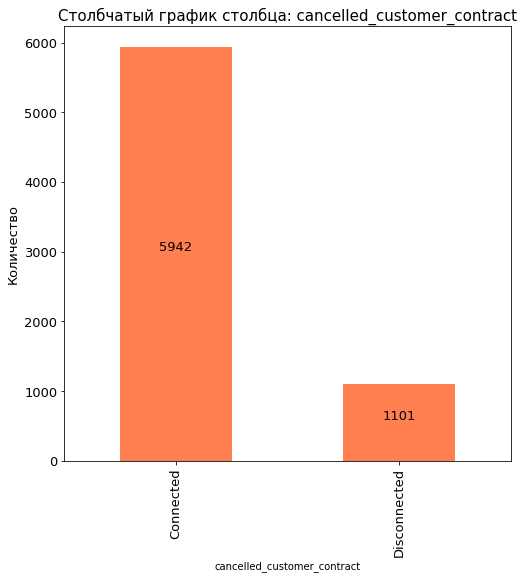

________________________________________________________________________


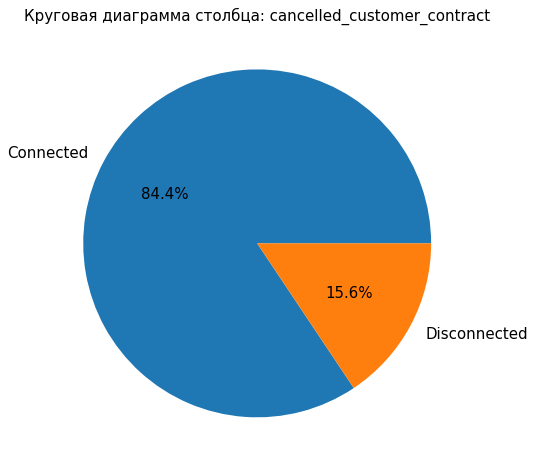

In [50]:
category_data_graf(df, 'cancelled_customer_contract')

Как мы видим у нас наблюдается дисбаланс классов. Мы не будем делать андер\овер семплинг, но должны это учесть при создании модели. Также видим, что 15,6% от всех пользователей отказалась от пользования услугами.

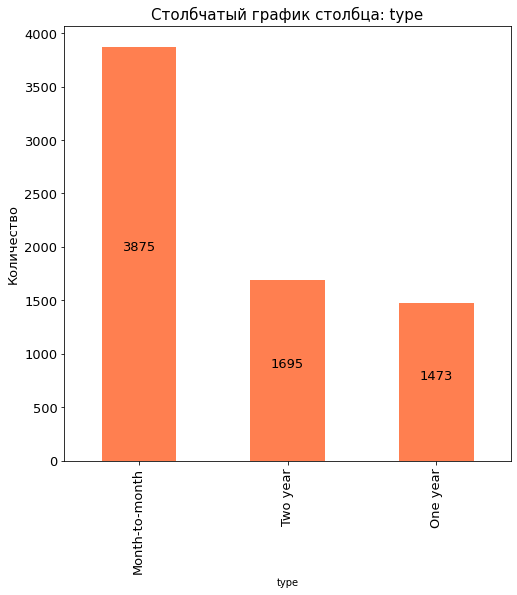

________________________________________________________________________


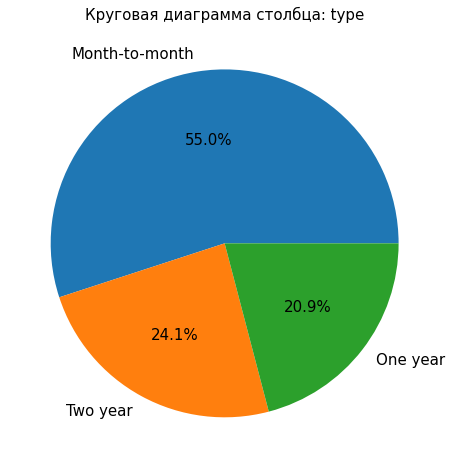

In [51]:
category_data_graf(df, 'type')

Как мы видим самым популярным способом оплаты это помесячная. По возможности хотелось бы узнать, что происходит с абонентом при изменении способа оплаты. Меняют ли в данных только поле способ оплаты? Или закрывают договор и создают новый? У нас могут быть ситуации, когда клиент пользовался 12 месяцев помесячной оплатой, а потом перешел на годовую. В таком случае сейчас он идет как пользователь с годовой оплатой, хотя все время он таким не был. По возможности было бы неплохо увидеть среди признаков данные о смене способа оплаты, так как эти признаки моглы бы дыть доп информацию для модели. Возможно если клиент переходит с помесячной оплаты на годовую означает, что клиент не хочет прекращать договор, а вот переход с годовой на месячную может говорить об скором отключении от услуг. 

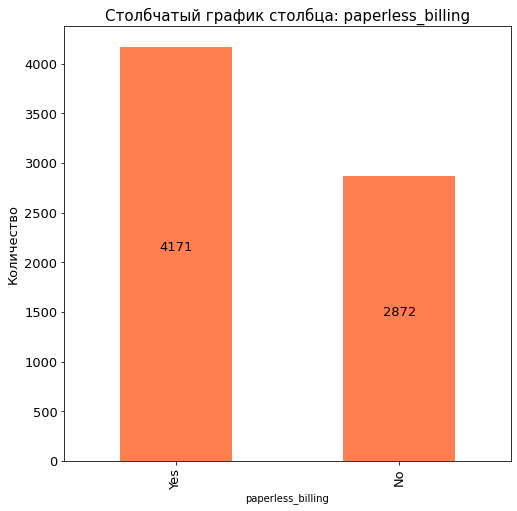

________________________________________________________________________


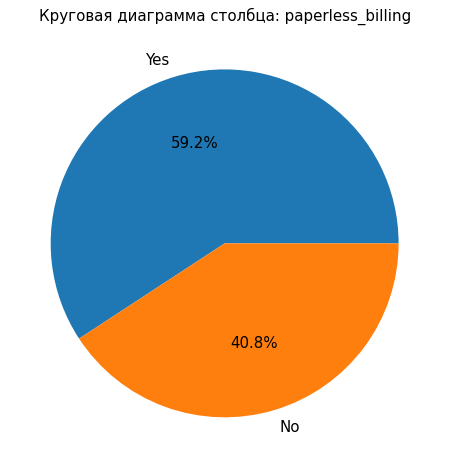

In [52]:
category_data_graf(df, 'paperless_billing')

59% абонентов получают информацию об оплате в электронном виде, а 41% получают бумажные версии.

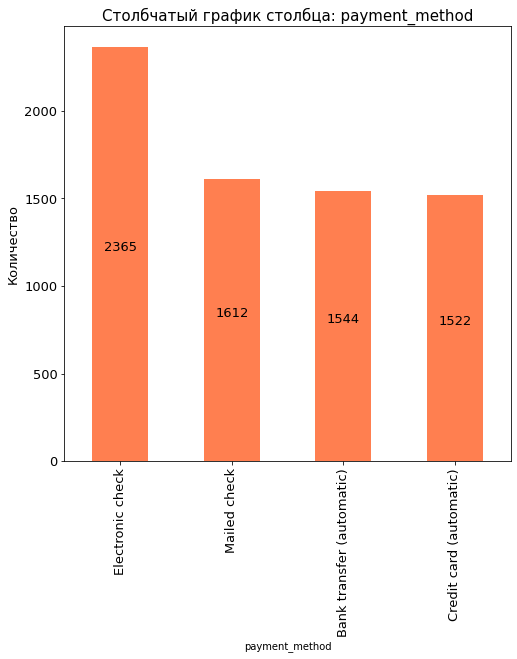

________________________________________________________________________


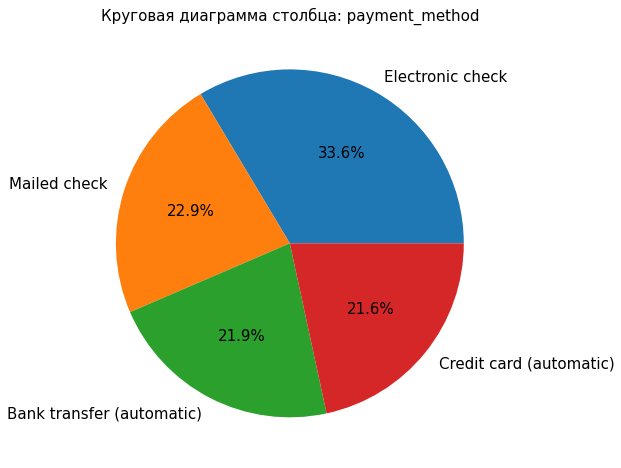

In [53]:
category_data_graf(df, 'payment_method')

Распределение по типам платежа выглядит равномерным с небольшим лидерством Electronic check

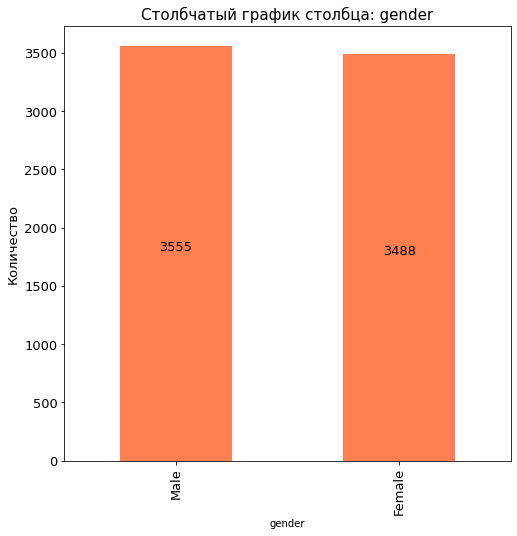

________________________________________________________________________


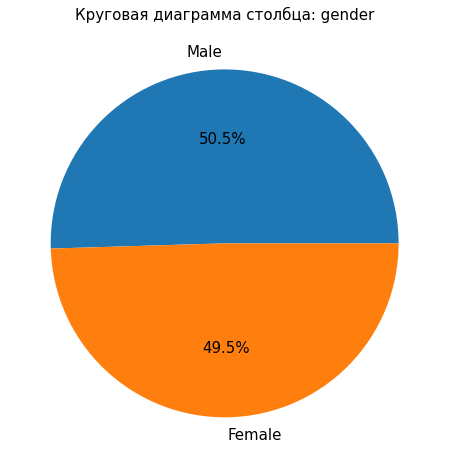

In [54]:
category_data_graf(df, 'gender')

А вот распределние по половому признаку почти 50 на 50. Разница всего 67 человек

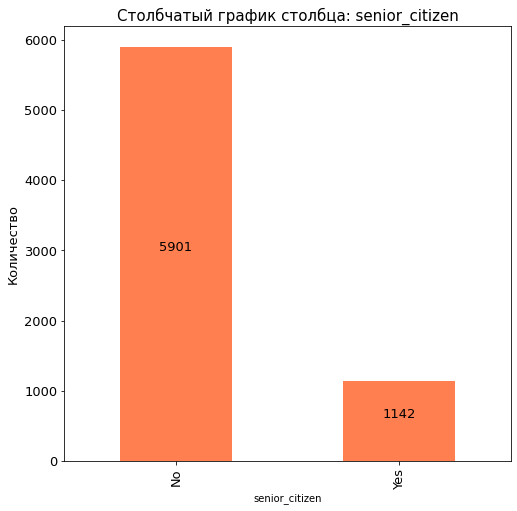

________________________________________________________________________


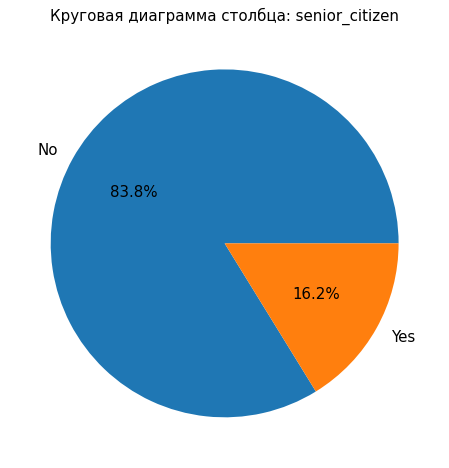

In [55]:
category_data_graf(df, 'senior_citizen')

Как мы видим пенсионеров у нас не так много, всего 16%

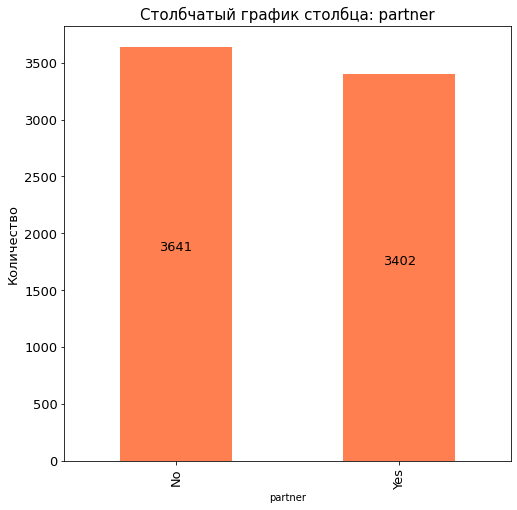

________________________________________________________________________


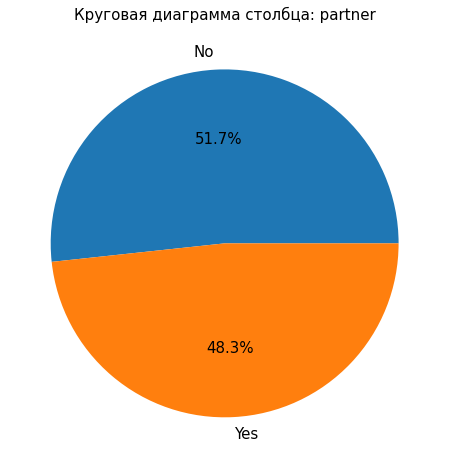

In [56]:
category_data_graf(df, 'partner')

Женаты/замужем порядка 50% абонентов

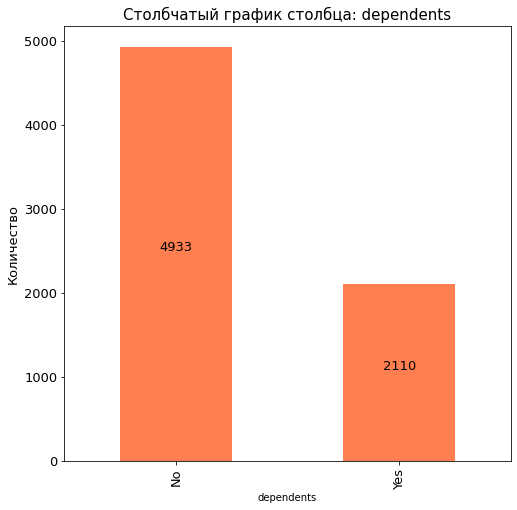

________________________________________________________________________


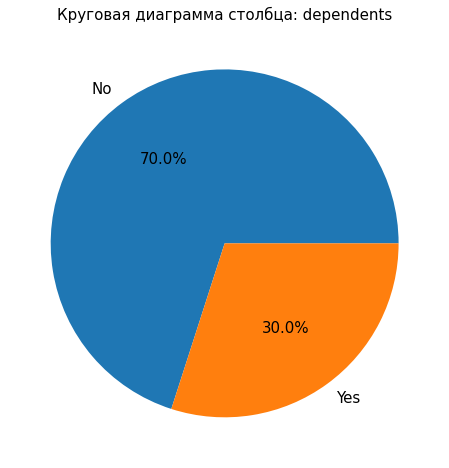

In [57]:
category_data_graf(df, 'dependents')

А вот дети есть только у 30% респондентов

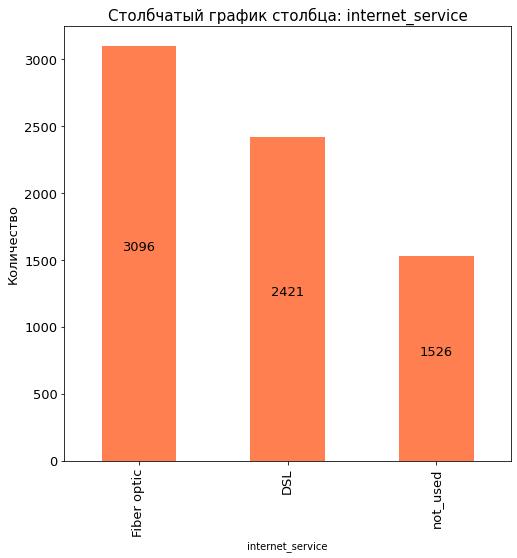

________________________________________________________________________


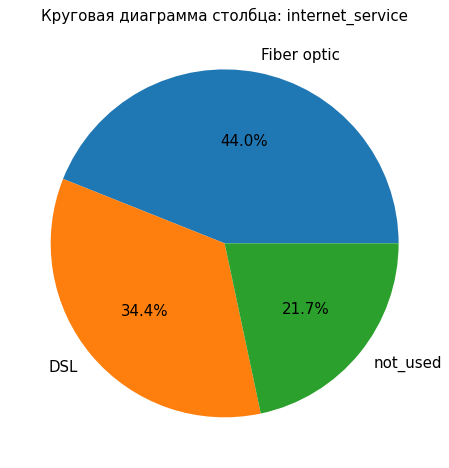

In [58]:
category_data_graf(df, 'internet_service')

44% пользователей использует оптоволокно. 22% абонентов не используют интернет

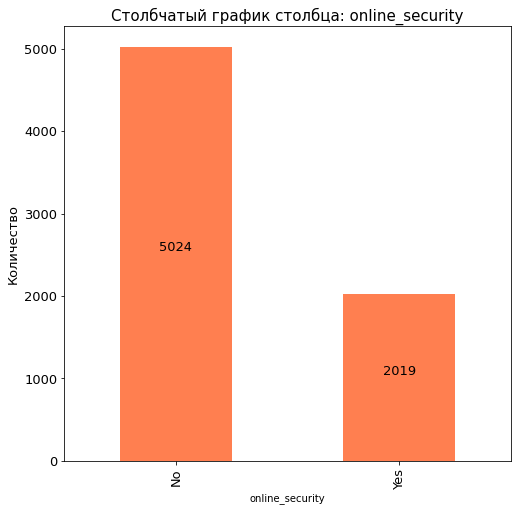

________________________________________________________________________


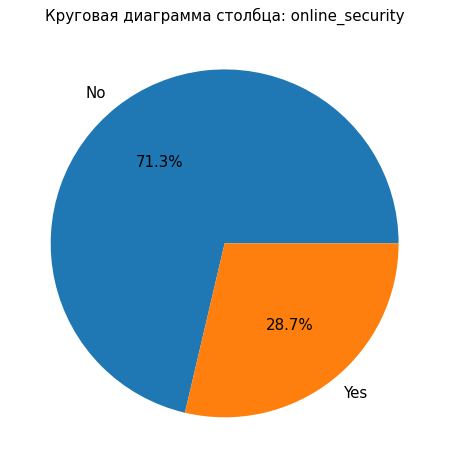

In [59]:
category_data_graf(df, 'online_security')

Программой блокировки опасных сайтов пользуются почти 29% всех пользователей

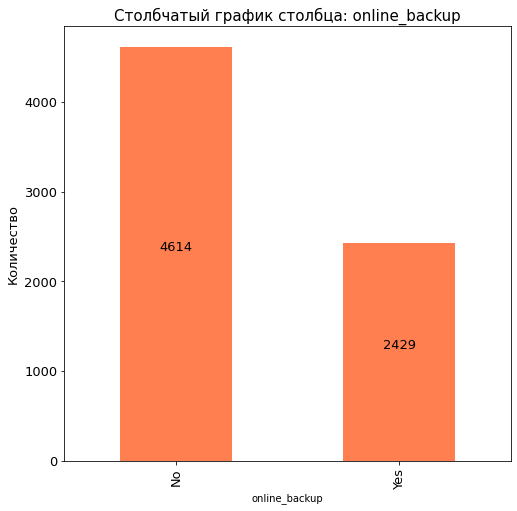

________________________________________________________________________


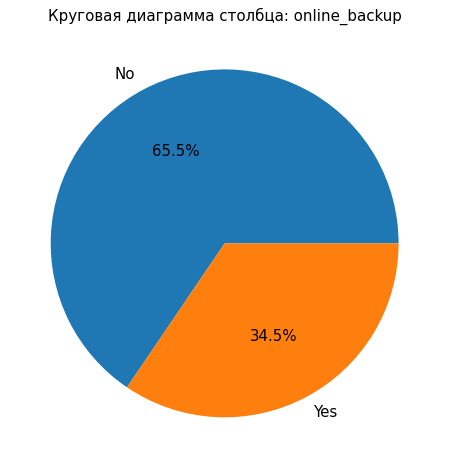

In [60]:
category_data_graf(df, 'online_backup')

Облачным хранилищем пользуются 34,5% пользователей

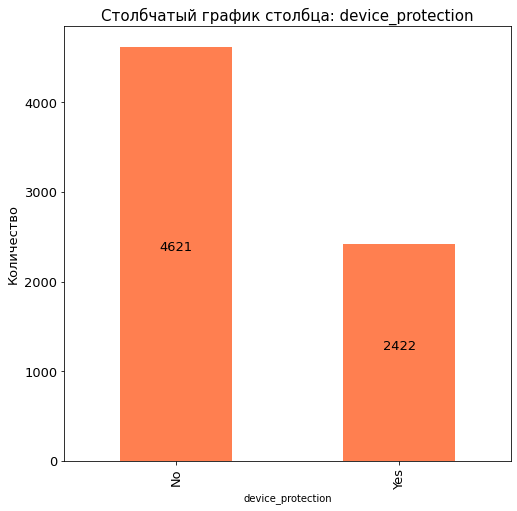

________________________________________________________________________


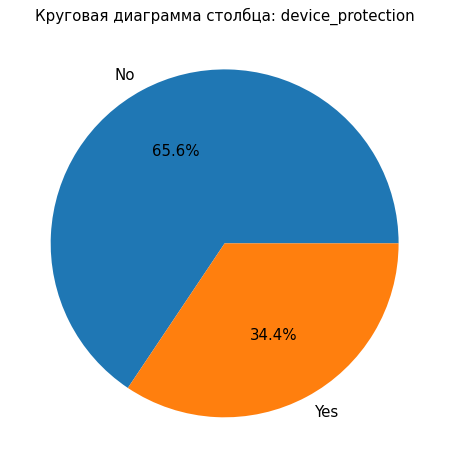

In [61]:
category_data_graf(df, 'device_protection')

Почти столько же пользуются антивирусом

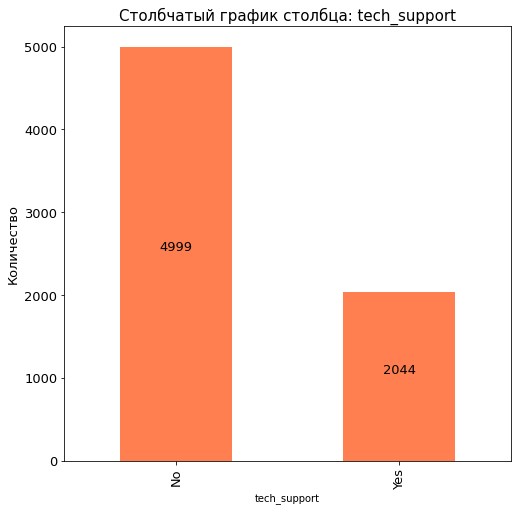

________________________________________________________________________


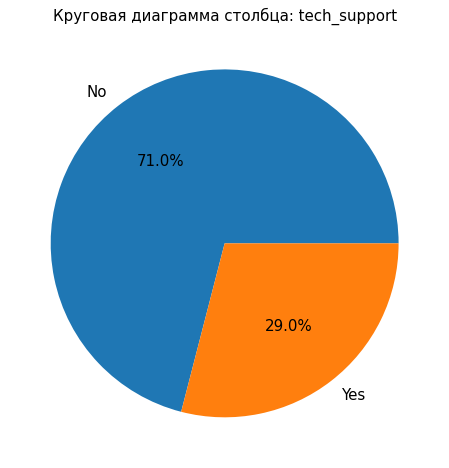

In [62]:
category_data_graf(df, 'tech_support')

29% пользуются выделеной линией поддержки

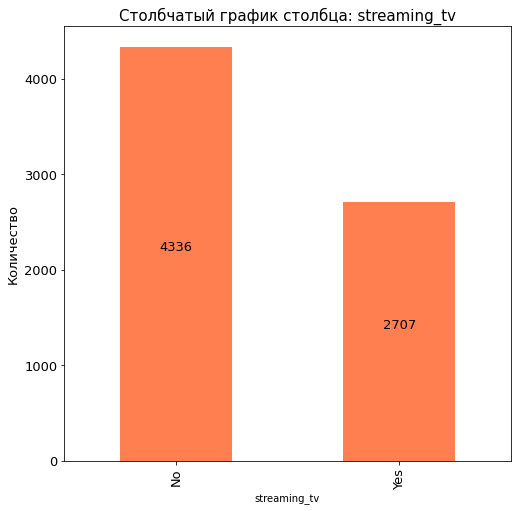

________________________________________________________________________


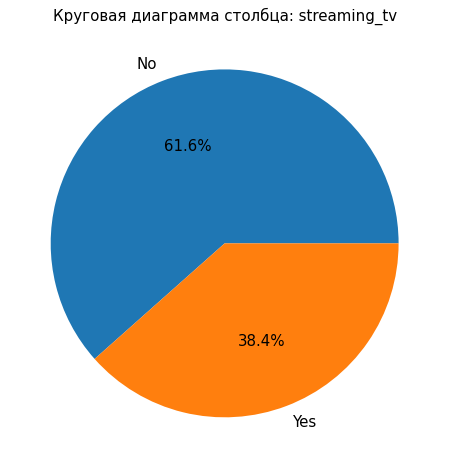

In [63]:
category_data_graf(df, 'streaming_tv')

А вот стриминговое телевидение подключили почти 39% пользователей

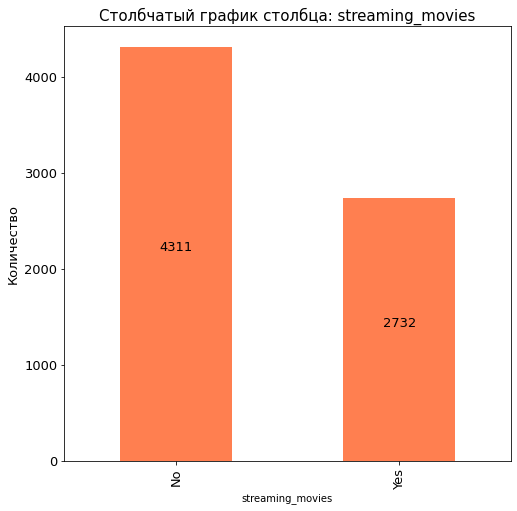

________________________________________________________________________


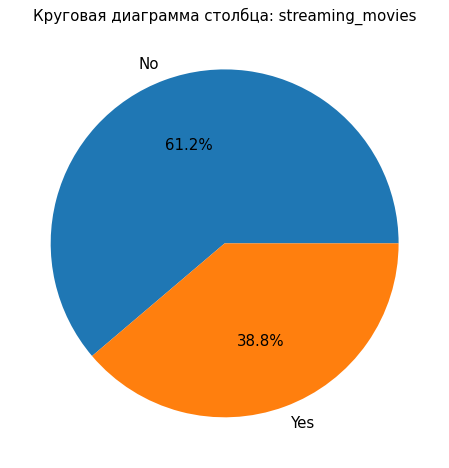

In [64]:
category_data_graf(df, 'streaming_movies')

Каталог фильмов подключили на 25 человек больше, чем телевидение

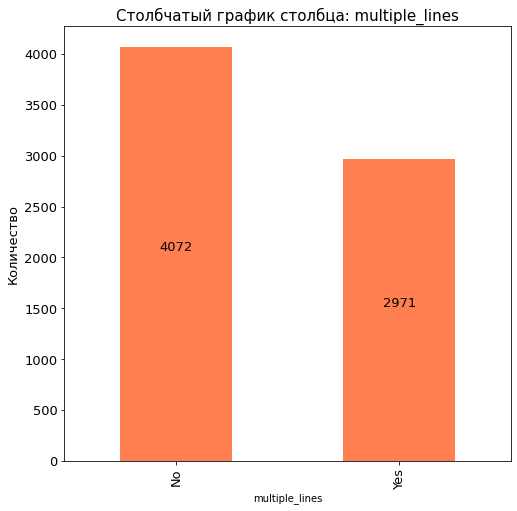

________________________________________________________________________


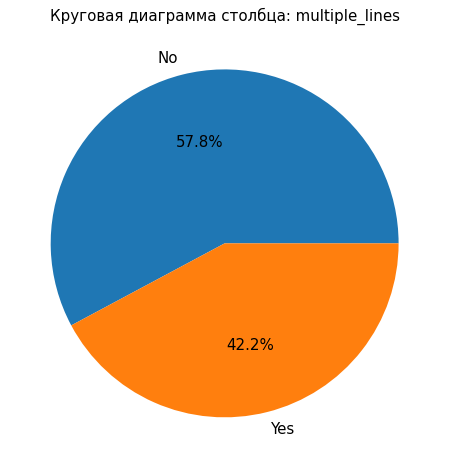

In [65]:
category_data_graf(df, 'multiple_lines')

42% абонентов подключенили телефон к нескольким линиям одновременно.

<a id='section11'></a> 
### Анализ количественных столбцов

Теперь проведем исследовательский анализ количественных признаков

In [66]:
def number_data_graf(dataset, column, bins):
    '''Данная функция берет на себя функцию построения гистограммы, а также "Ящик с усами", 
    для определния распределения и выбросов. 
    Аргументы:
    dataset - выбор датасета (значение без кавычек)
    columns - выбор столбца для построения графиков (значение в кавычках)
    bins - число столбцов в гистограмме'''
    
    plt.figure(figsize=(10,5))
    dataset[column].hist(bins=bins, color='coral', edgecolor='darkblue', linewidth=1.2)
    plt.title(f'Гистограмма столбца: {column}', fontsize=15)
    plt.xlabel('Частота распределения',fontsize=13)
    plt.ylabel('Количество',fontsize=13)
    plt.show()
    
    plt.figure(figsize=(10.3, 2))
    sns.boxplot(data=dataset[column], orient='h', color='coral')
    plt.ylabel('Ящик с "усами"',fontsize=13)
    plt.show()
    
    print(dataset[column].describe())

Начнем с признака время пользования

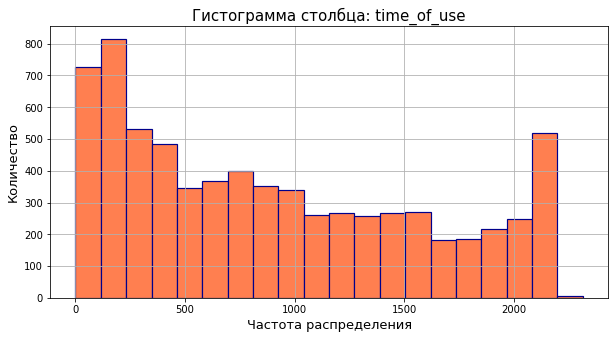

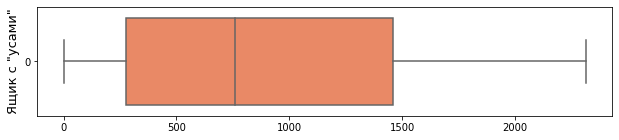

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: time_of_use, dtype: float64


In [67]:
number_data_graf(df, 'time_of_use', 20)

Как мы видим каких-то аномальных значений или выбросов не наблюдается. Также стоит отметить, что большое количество пользователей со сроком пользования от 0 до 500 дней по сравнению с теми кто пользуется от 500 до 1000 и т.д. Нужно позже проверить это речь о новых подключениях или о коротком сроке пользования нашими услугами

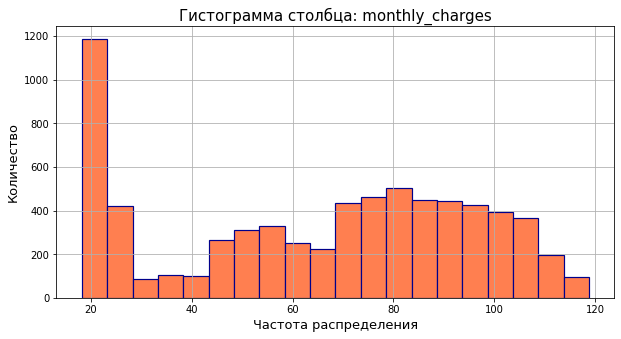

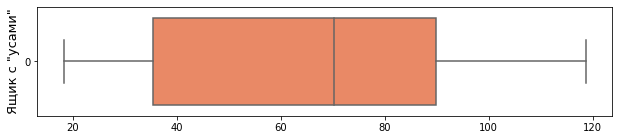

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64


In [68]:
number_data_graf(df, 'monthly_charges', 20)

Выделяется интервал от 15 до 25. Скорее всего, он соответствует минимально необходимому ежемесячному платежу. Выбросов и аномальных значений нет

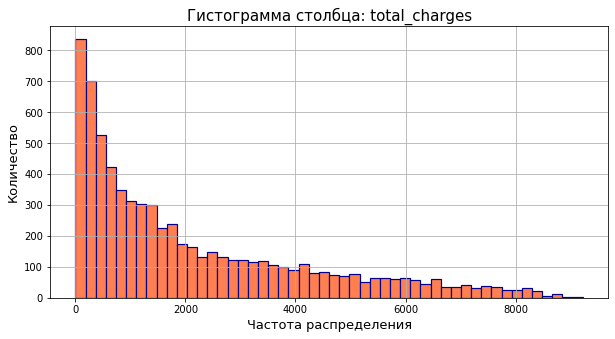

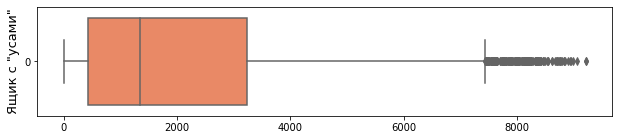

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64


In [69]:
number_data_graf(df, 'total_charges', 50)

Хоть по "Ящику с усами" наблюдаются выбросы, на деле это могут быть самые старые клиенты и у которых найбольшее количество дней пользования. Большое количество околонулевых размеров платежа может говорить о том, что многие клиенты заключают договор на помесячную оплату услуг и пользуются ими недолгое время или новых пользователей становится больше.

<a id='section12'></a> 
### Анализ портрета отключенных абонентов

Мы не будем анализировать каждый признак, как делали это в предыдущем блоке, а напишем цикл и выведем данные по всем типам типа object

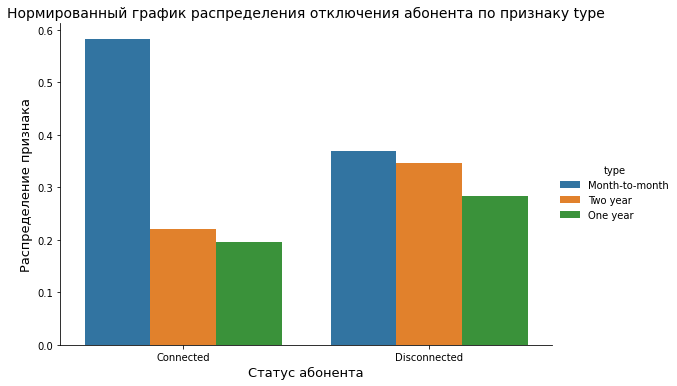

____________________________________________________________________________________________________ 



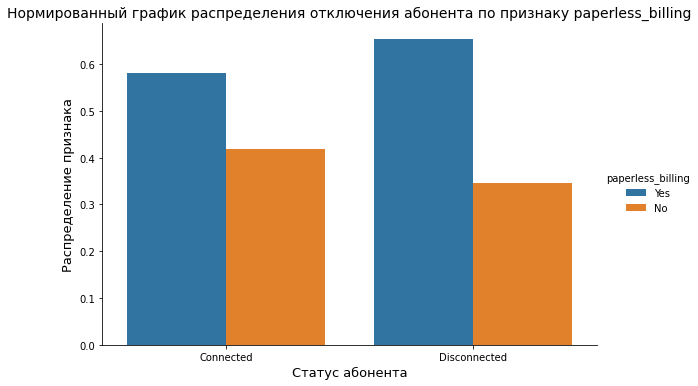

____________________________________________________________________________________________________ 



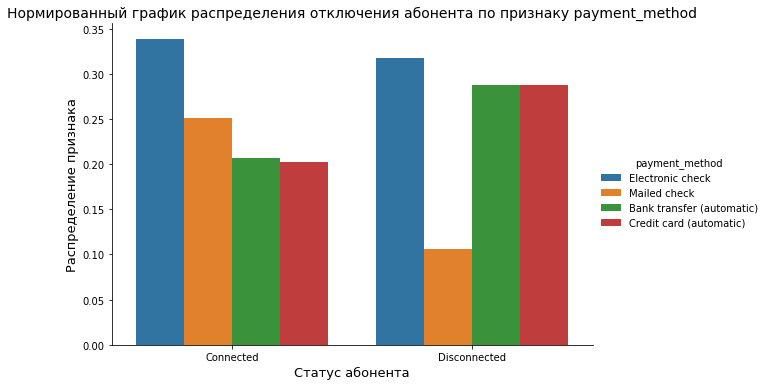

____________________________________________________________________________________________________ 



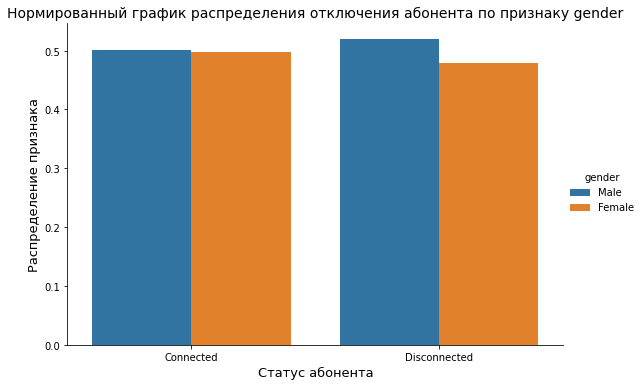

____________________________________________________________________________________________________ 



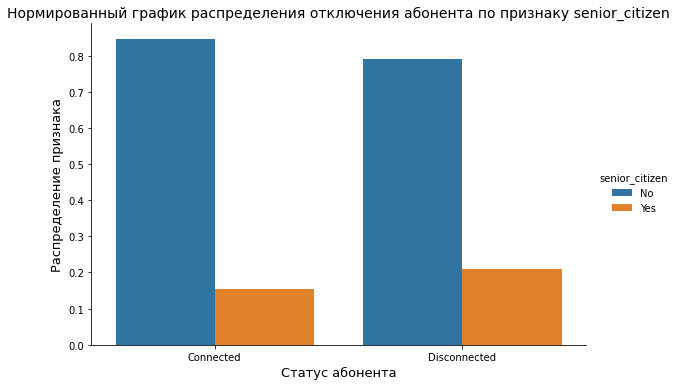

____________________________________________________________________________________________________ 



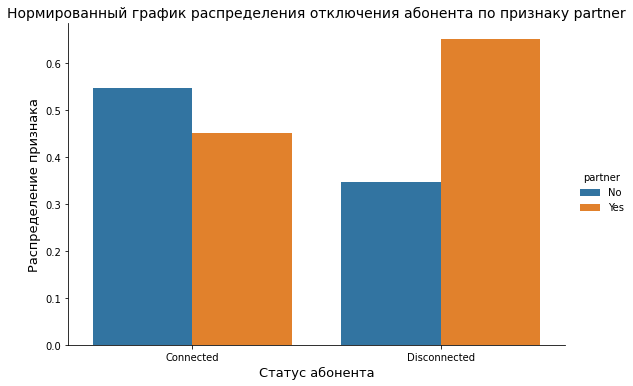

____________________________________________________________________________________________________ 



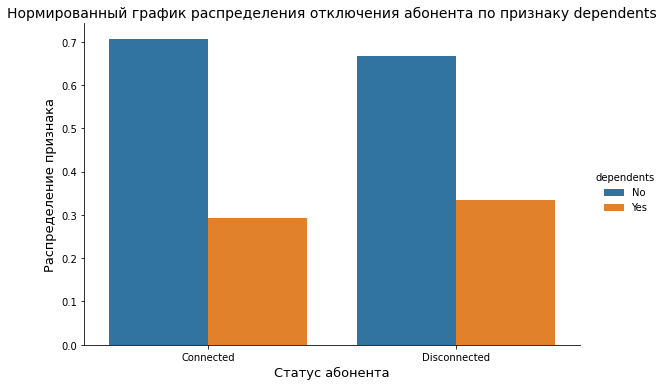

____________________________________________________________________________________________________ 



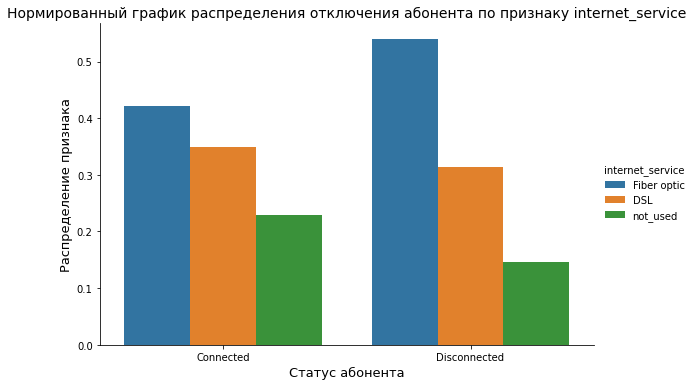

____________________________________________________________________________________________________ 



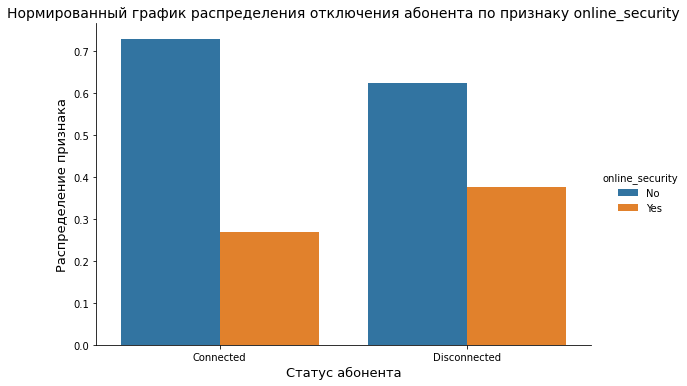

____________________________________________________________________________________________________ 



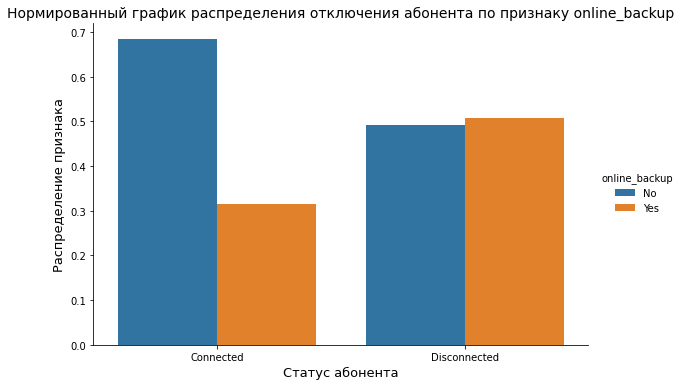

____________________________________________________________________________________________________ 



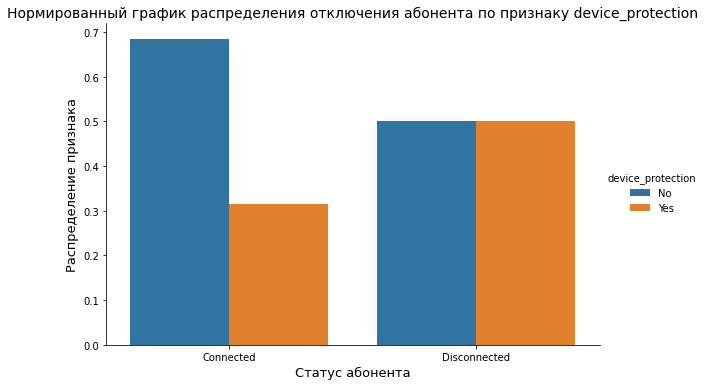

____________________________________________________________________________________________________ 



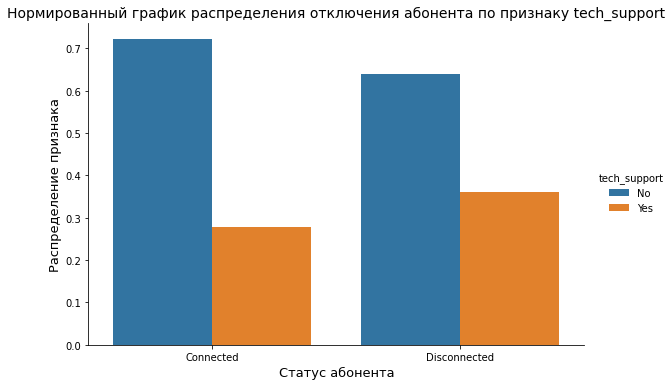

____________________________________________________________________________________________________ 



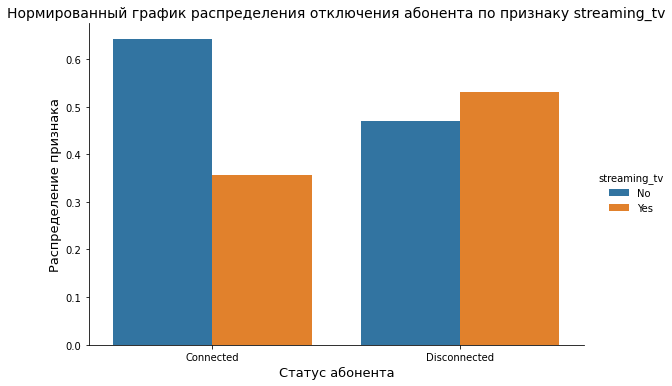

____________________________________________________________________________________________________ 



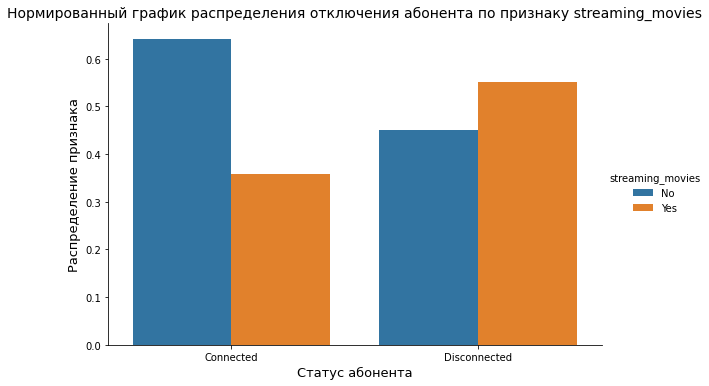

____________________________________________________________________________________________________ 



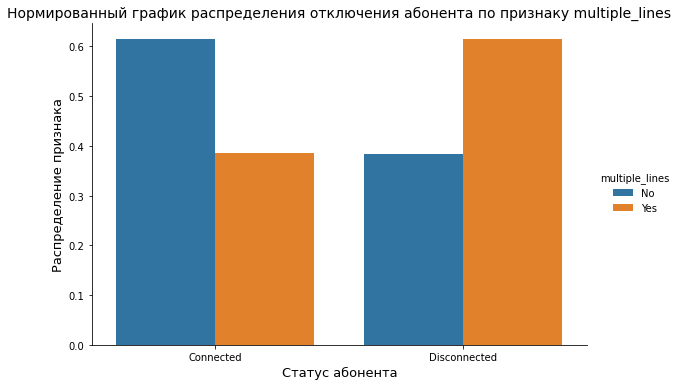

____________________________________________________________________________________________________ 



In [70]:
for column in df.columns.drop('cancelled_customer_contract'):
    if df[column].dtypes == 'object':
        x,y = 'cancelled_customer_contract', column
        graph = (df.groupby('cancelled_customer_contract')[column]
                 .value_counts(normalize=True)
                 .rename('percent')
                 .reset_index()
                 .pipe((sns.catplot, 'data'), x=x, y='percent', hue=y, kind='bar', height=5, aspect=1.5))
        plt.title(f'Нормированный график распределения отключения абонента по признаку {column}', fontsize=14)
        plt.ylabel('Распределение признака', fontsize=13)
        plt.xlabel('Статус абонента', fontsize=13)
        plt.show()
        print('_'*100, '\n')

Основные отклонения можно наблюдать в следующих признаках:

**type** - Тип оплаты каждый месяц в процентном соотношении менее склонен к отказу услуг

**paymond_method** - Тип платежа MailCheck менее склонен к отключению услуг

**partner** - Женатые люди чаще отключаются от наших услуг

**Подключение доп услуг** - дополнительные услуги такие как ТВ, несколько телефонных линий, онлайн защита и т.д. в равной мере влияют на отключение абонентов, хотя абонентов с такими услугами меньше

Теперь проверим количественные признаки

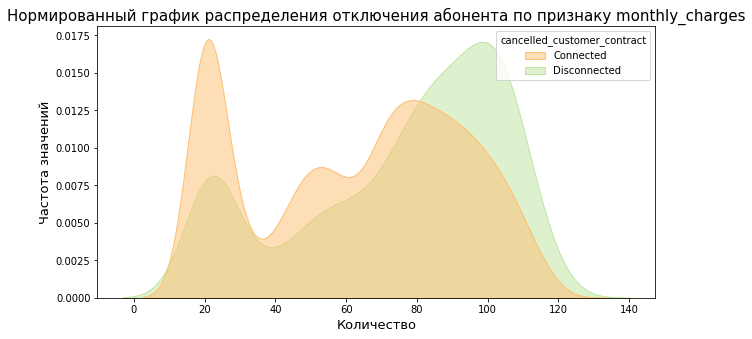

____________________________________________________________________________________________________ 



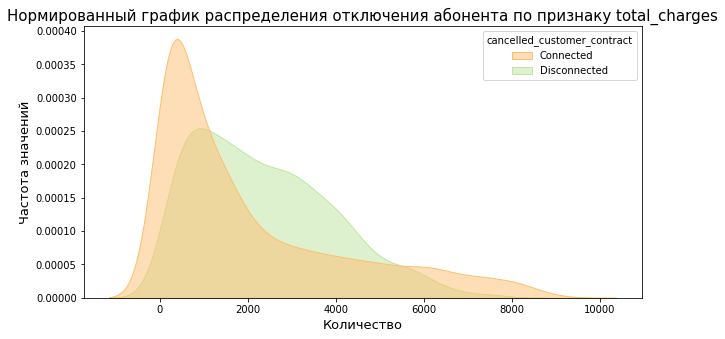

____________________________________________________________________________________________________ 



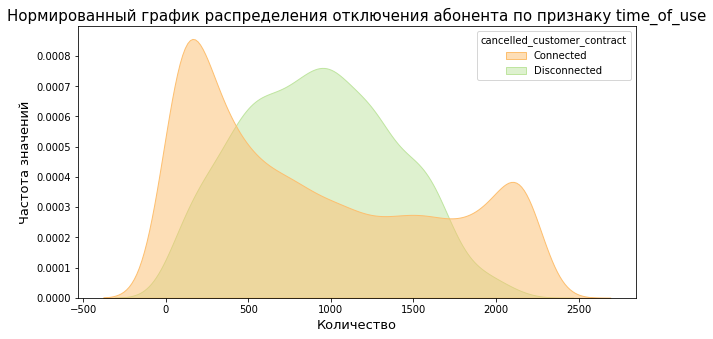

____________________________________________________________________________________________________ 



In [71]:
for column in df.columns.drop('cancelled_customer_contract'):
    if df[column].dtypes == 'float64':
        x,y = 'cancelled_customer_contract', column
        plt.figure(figsize=(10,5))
        sns.kdeplot(data=df, x=column, hue='cancelled_customer_contract', common_norm=False,
                   palette="Spectral", fill=True, alpha=.5)
        plt.title(f'Нормированный график распределения отключения абонента по признаку {column}', fontsize=15)
        plt.xlabel('Количество',fontsize=13)
        plt.ylabel('Частота значений',fontsize=13)
        plt.show()
        print('_'*100, '\n')

Чем выше ежемесячная стоимость, тем больше шансов на отключение услуг. Также как видно основной пик отключения клиентов приходится на 3-х летнее пользование, а далее начинает падать.

<a id='section13'></a> 
### Анализ тенденции на приток и отток клиентов

Проанализируем как за последнее время менялась тенденция к притоку и оттоку клиентов

Для этого создадим отдельный датасет с датой начала пользования услуг и является ли абонент нашим клиентом

In [72]:
begin_date = df[['begin_date', 'cancelled_customer_contract']]
begin_date['cancelled_customer_contract'] = np.where(begin_date['cancelled_customer_contract']=='Connected', 0, 1)

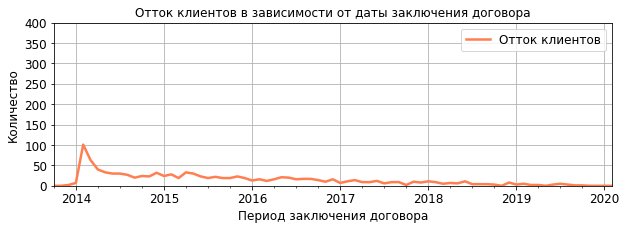

In [73]:
begin_date_plot = begin_date.groupby(
    'begin_date')['cancelled_customer_contract'].agg(['sum'])

begin_date_plot.columns = ['Отток клиентов']

begin_date_plot['Отток клиентов'].plot(
        figsize=(10, 3),
        linewidth = 2.5,
        color = 'coral',
        fontsize = 12,
        grid = True)

plt.title('Отток клиентов в зависимости от даты заключения договора',
          fontsize = 12)
plt.ylim(0, 400)
plt.xlabel('Период заключения договора', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

Как мы видим каких-то всплесков в оттоке клиентов не наблюдается. Стоит обратить внимание на то, что существует всплеск в оттоке старых клинетов. На них стоит обратить особое внимание при формировании акционных предложений.

Дополнительно изобразим динамику заключения новых договоров

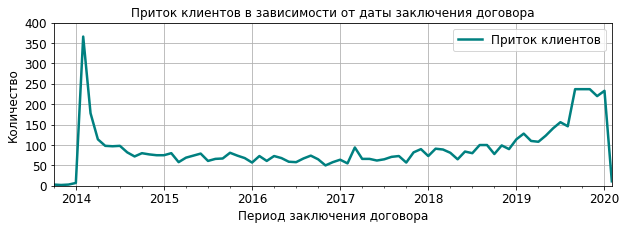

In [74]:
customer_inflow = begin_date.groupby(
    'begin_date')['cancelled_customer_contract'].agg(['count'])

customer_inflow.columns = ['Приток клиентов']

customer_inflow['Приток клиентов'].plot(
        figsize=(10, 3),
        linewidth = 2.5,
        color = 'teal',
        fontsize = 12, grid = True
)
plt.title('Приток клиентов в зависимости от даты заключения договора',
          fontsize = 12)
plt.ylim(0, 400)
plt.xlabel('Период заключения договора', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

Как мы видим в начале работы компании был всплеск в притоке новых пользователей, как и наблюдается увеличенная тенденция в последние пол года. В среднем с 2015 по 2019 год в месяц был приток от 50 до 100 новых клиентов. Такую же информацию по притоку клиентов нам дала столбчатая гистограмма

<a id='section14'></a> 
### Корреляционный анализ признаков

Проверим наши признаки на корреляцию. Для начала нужно определить список нумерических столбцов, чтобы был верно проведен корреляционный анализ

In [75]:
interval_cols = df.select_dtypes('number').columns.tolist()
interval_cols

['monthly_charges', 'total_charges', 'time_of_use']

Список столбцов верен, теперь можно строить матрицу

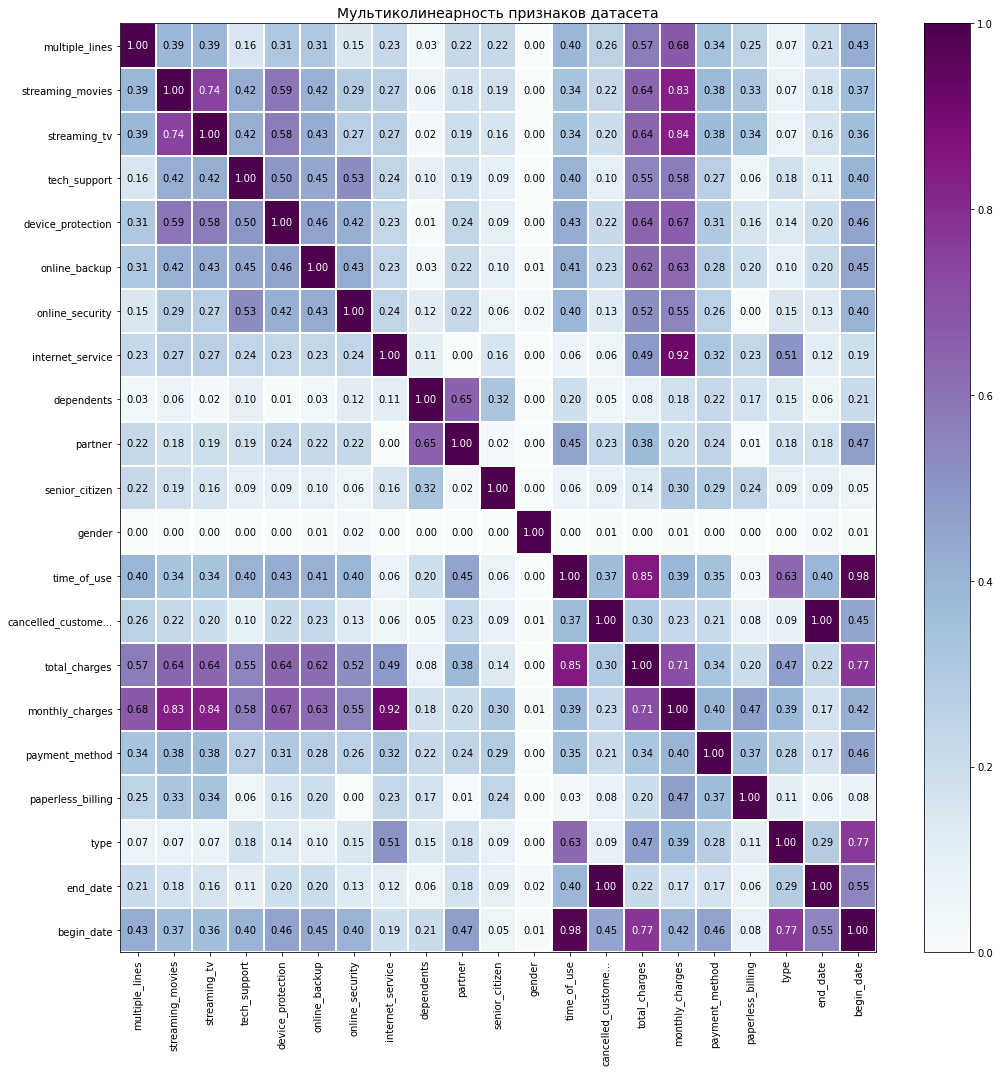

In [76]:
phik_overview = df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='BuPu',
    title=r'Мультиколинеарность признаков датасета',
    fontsize_factor=1,
    figsize=(15, 15))

По шкале Чеддока высокая корреляция между признаками наступает когда коеффициент более 0.90. Как мы видим наш признак **end_date** полностью коррелирует с целевым признаком **cancelled_customer_contract**. Это не удивительно, так как для всех клиентов, которые продолжают пользоваться услугами, стоит дата нашей заглушки 2020-02-01 и если дата отличается, то клиент точно расторг договор. Также можно наблюдать мультиколлениарность между признаками **begin_date** и **time_of_use**, поскольку один выходит из другого, и признаками **monthly_changes** и **internet_service**. В целом любое значение влиящиее на стоимоть услуг будет коррелировать с ежемесячным и годовым платежом, так как одно выходит из другого.

Для нашей модели лучше оставлять признаки которые сильнее коррелируют с целевым, а это значит, что мы удалим 3 признака:

**end_date** - как утечку данных с полной корреляцией

**internet_service** и **begin date** - как признаки с высокой мультиколлениарностью с признаками **monthly_changes** и **time_of_use**, но оставленные признаки сильнее коррелируют с целевым признаком

In [77]:
df.shape

(7043, 21)

In [78]:
df.drop(['internet_service', 'end_date',  'begin_date'], axis = 1, inplace = True)

In [79]:
df.shape

(7043, 18)

In [80]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,cancelled_customer_contract,time_of_use,gender,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Connected,31.0,Female,No,Yes,No,No,Yes,No,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Connected,1036.0,Male,No,No,No,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Connected,123.0,Male,No,No,No,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Connected,1371.0,Male,No,No,No,Yes,No,Yes,Yes,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Connected,153.0,Female,No,No,No,No,No,No,No,No,No,No


<a id='section15'></a> 
### Выводы по исследовательскому анализу данных

**1** - Проведен анализ каждого категиального и количественного прихзнака в датасете

**2** - Проведен анализ на мультиколлениарность признаков

**3** - По результату корреляционного анализа были удалены 3 признака из нашего датасета, поскольку это была утечка в данных (столбец **end_date**) и высокая мультиколлениарность (столбцы **internet_service** и **begin date**)

## Часть 5. Подготовка данных и Обучение моделей

<a id='section16'></a> 
### Разделение данных на обучающую и тестовую выборку

До разделения данных мы закодируем наш целевой признак через **LabelEncoder**

In [81]:
label_encoder = LabelEncoder()
df['cancelled_customer_contract'] = label_encoder.fit_transform(df['cancelled_customer_contract'])

С точки зрения логики, желательно, чтобы отключенные абоненты были отмечены 1. Проверим как было проведено кодирование

In [82]:
contract_new['cancelled_customer_contract'].head(20)

customer_id
7590-VHVEG       Connected
5575-GNVDE       Connected
3668-QPYBK       Connected
7795-CFOCW       Connected
9237-HQITU       Connected
9305-CDSKC       Connected
1452-KIOVK       Connected
6713-OKOMC       Connected
7892-POOKP       Connected
6388-TABGU    Disconnected
9763-GRSKD       Connected
7469-LKBCI       Connected
8091-TTVAX       Connected
0280-XJGEX       Connected
5129-JLPIS       Connected
3655-SNQYZ    Disconnected
8191-XWSZG       Connected
9959-WOFKT       Connected
4190-MFLUW       Connected
4183-MYFRB       Connected
Name: cancelled_customer_contract, dtype: object

In [83]:
df['cancelled_customer_contract'].head(20)

customer_id
7590-VHVEG    0
5575-GNVDE    0
3668-QPYBK    0
7795-CFOCW    0
9237-HQITU    0
9305-CDSKC    0
1452-KIOVK    0
6713-OKOMC    0
7892-POOKP    0
6388-TABGU    1
9763-GRSKD    0
7469-LKBCI    0
8091-TTVAX    0
0280-XJGEX    0
5129-JLPIS    0
3655-SNQYZ    1
8191-XWSZG    0
9959-WOFKT    0
4190-MFLUW    0
4183-MYFRB    0
Name: cancelled_customer_contract, dtype: int64

Кодирование прошло успешно

Для начала разделим данные на обучающую и тестовую выборки

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['cancelled_customer_contract'], axis=1),
    df['cancelled_customer_contract'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['cancelled_customer_contract'])

После разделения данных необходимо убедится, что выборки поделились корректно.

In [85]:
X_train.shape, y_train.shape

((5282, 17), (5282,))

In [86]:
X_test.shape, y_test.shape

((1761, 17), (1761,))

Также нужно проверить, что выборки поделились с учетом распределения целевого признака

In [87]:
y_train.value_counts(normalize = True)

cancelled_customer_contract
0    0.84362
1    0.15638
Name: proportion, dtype: float64

In [88]:
y_test.value_counts(normalize = True)

cancelled_customer_contract
0    0.843839
1    0.156161
Name: proportion, dtype: float64

Как мы видим разделение прошло успешно как в объеме, так и по целевому признаку

<a id='section17'></a> 
### Создание пайплайна и модели для Логистической регрессии

Для кодировки категориальных признаков нужно использовать **OneHotEncoder** для не ранговых признаков и **OrdinalEncoder** для ранговых признаков. Также **OrdinalEncoder** подходит для деревянных моделей

Для масштабирования нумерических признаков мы воспользуемся **StandardScaler** и **MinMaxScaler**

Для начала создадим список столбцов для нужной кодировки или масштабирования

In [89]:
datatype = df.dtypes

In [90]:
cat_columns = datatype[(datatype == 'object')].index.tolist()
cat_columns

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [91]:
num_columns = datatype[(datatype == 'float64')].index.tolist()
num_columns

['monthly_charges', 'total_charges', 'time_of_use']

Все признаки по типам распределились верно

Создаём часть пайплайна для подготовки признаков из списка ohe_columns

Чтобы сделать наш пайплайн универсальным, мы добавим в них возможность заполнения пустых значений модой через **SimpleImputer**, поскольку в будущем в нашем датасете могут быть пустые значения. Так как у нас нет ранговых признаков, то будем использовать только **OneHotEncoder** для нашей линейной модели

In [92]:
pre_lin_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='No')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
    )

Создаём пайплайн для подготовки данных в который добавим масштабирование нумерических признаков

In [93]:
data_preprocessor_log_reg = ColumnTransformer(
    [('ohe', pre_lin_pipe, cat_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough', 
)

Создаём итоговый пайплайн: подготовка данных и модель

In [94]:
pipe_final_log_reg = Pipeline([
    ('preprocessor', data_preprocessor_log_reg),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

Создаем словарь гиперпараметров для модели **LogisticRegression**

In [95]:
param_grid_log_reg = {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__penalty' : ['l1','l2', 'elasticnet', None],
        'models__C': range(1, 11, 2),
        'models__solver' : ['lbfgs', 'liblinear', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
        }

Проверим как работает модель и найдем лучшие параметы с помощью полного поиска по сетке GridSearchCV

In [96]:
grid_search_log_reg = GridSearchCV(
    pipe_final_log_reg, 
    param_grid_log_reg, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1)


grid_search_log_reg.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search_log_reg.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method'

In [97]:
print ('Метрика ROC_AUC лучшей модели на тренировочной выборке с кросвалидацией:', round(grid_search_log_reg.best_score_, 3))

Метрика ROC_AUC лучшей модели на тренировочной выборке с кросвалидацией: 0.769


Как мы видим метрика ROC_AUC составила 0.769. Попробуем другие модели на безе Дерева решении

Сохраним нашу оценку в отдельную переменную

In [98]:
log_reg_roc_auc = round(abs(grid_search_log_reg.best_score_), 3)

<a id='section18'></a> 
### Создание пайплайна и модели для Дерева Решении

Для всех моделей, основанных на решающих деревьях, обработка числовых признаков не требуется, поэтому препроцессор будет создан только для категориальных признаков. Также, чтобы не создавать большого количества признаков после **OneHotEncoder** мы воспользуемся **OrdinalEncoder**, поскольку он также сможет верно обрабатывать данные

In [99]:
pre_tree_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='No')),
     ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))]
    )

In [100]:
data_preprocessor_tree = ColumnTransformer(
    [('ord', pre_tree_pipe, cat_columns),
     ], 
    remainder='passthrough', 
)

In [101]:
pipe_final_tree = Pipeline([
    ('preprocessor', data_preprocessor_tree),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Теперь создадим словарь с параметрами и запустим поиск по сетке для Дерева решений

In [102]:
param_grid_tree = {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11, 2),
        'models__min_samples_leaf': range(2, 16, 2),
        'models__max_features': range(2, 23, 2),
    }

In [103]:
grid_search_tree = GridSearchCV(
    pipe_final_tree, 
    param_grid_tree, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1)


grid_search_tree.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search_tree.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'pa

In [104]:
print ('Метрика ROC_AUC лучшей модели на тренировочной выборке с кросвалидацией:', round(grid_search_tree.best_score_, 3))

Метрика ROC_AUC лучшей модели на тренировочной выборке с кросвалидацией: 0.796


Как мы видим модель справилась немного лучше с метрикой ROC_AUC 0.796

Сохраним нашу оценку в переменную

In [105]:
tree_roc_auc = round(abs(grid_search_tree.best_score_), 3)

<a id='section19'></a> 
### Обучение модели Случайного Леса

Пайплайн для предобработки данных уже создан, значит нужно создать только параметры модели

In [106]:
param_grid_rf = {
        'models': [RandomForestClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(3, 16, 3),
        'models__n_estimators': range(50, 401, 50),
    }

In [107]:
grid_search_rf = GridSearchCV(
    pipe_final_tree, 
    param_grid_rf, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1)


grid_search_rf.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search_rf.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'pa

In [108]:
print ('Метрика ROC_AUC лучшей модели на тренировочной выборке с кросвалидацией:', round(grid_search_rf.best_score_, 3))

Метрика ROC_AUC лучшей модели на тренировочной выборке с кросвалидацией: 0.834


Сохраним нашу оценку в отдельную переменную

In [109]:
rf_roc_auc = round(abs(grid_search_rf.best_score_), 3)

<a id='section20'></a> 
### Обучение модели CatBoostClassifier

Для модели CatBoost не нужна дополнительная кодировка признаков. Главное передать в нужный параметр категориальные столбцы. Чтобы CatBoost заработал нужно добавить "обходной путь" для совместимости версии

In [110]:
pd.DataFrame.iteritems = pd.DataFrame.items

In [111]:
catboost = CatBoostClassifier(random_state = RANDOM_STATE, verbose=0, iterations=500, 
                              cat_features=cat_columns, eval_metric='AUC')

In [112]:
pipe_catboost = Pipeline([
    ('catboost', catboost)
])

Cоздаем словарь с гиперпараметрами для отбора лучших гиперпараметров с помощью кроссвалидации

In [113]:
params_catboost = {
    'catboost__learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'catboost__loss_function': ['MultiClass', 'Logloss'],
}

In [114]:
grid_catboost = GridSearchCV(
    pipe_catboost,
    params_catboost,
    scoring = 'roc_auc',
    cv = 5,
    n_jobs = -1)

grid_catboost.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_catboost.best_params_)

Лучшая модель и её параметры:

 {'catboost__learning_rate': 0.1, 'catboost__loss_function': 'Logloss'}


In [115]:
print ('Метрика ROC_AUC лучшей модели на тренировочной выборке с кросвалидацией:', round(grid_catboost.best_score_, 3))

Метрика ROC_AUC лучшей модели на тренировочной выборке с кросвалидацией: 0.903


Сохраним нашу оценку в отдельную переменную

In [116]:
catboost_roc_auc = round(abs(grid_catboost.best_score_), 3)

<a id='section21'></a> 
### Обучение константной модели

In [117]:
dummy = DummyClassifier(random_state = RANDOM_STATE)

In [118]:
pipe_dummy = Pipeline([
    ('tree_preprocessor', data_preprocessor_log_reg),
    ('dummy', dummy)
])

Создадим словарь с разными константами

In [121]:
params_dummy = {
    'dummy__strategy': ['most_frequent',
                        'prior',
                        'stratified',
                        'uniform']
}

In [122]:
grid_dummy = RandomizedSearchCV(
    pipe_dummy,
    params_dummy,
    scoring = 'roc_auc',
    cv = 5,
    n_jobs = -1)

grid_dummy.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_dummy.best_params_)

Лучшая модель и её параметры:

 {'dummy__strategy': 'stratified'}


In [123]:
dummy_roc_auc = round(abs(grid_dummy.best_score_), 3)

print('Метрика ROC_AUC лучшей модели на тренировочной выборке с кросвалидацией', dummy_roc_auc) 

Метрика ROC_AUC лучшей модели на тренировочной выборке с кросвалидацией 0.504


Как мы видими метрика получилась найменьшая среди всех моделей

<a id='section22'></a> 
### Вывод по обучениям моделей

Давайте соберем все оценки наших моделей и построим график, чтобы наглядно увидеть метрики

In [124]:
summary_results = pd.DataFrame(
    {'1': ['Логистическая регрессия', log_reg_roc_auc],
     '2': ['Дерево решений', tree_roc_auc],
     '3': ['Случайный лес', rf_roc_auc],
     '4': ['Catboost', catboost_roc_auc],
     '5': ['Константная модель',dummy_roc_auc]
    }
)

summary_results = summary_results.T
summary_results.columns = ['Модель (ансамбль моделей)', 'ROC_AUC']
summary_results = summary_results.sort_values(by = 'ROC_AUC', ascending = False).reset_index(drop = True)

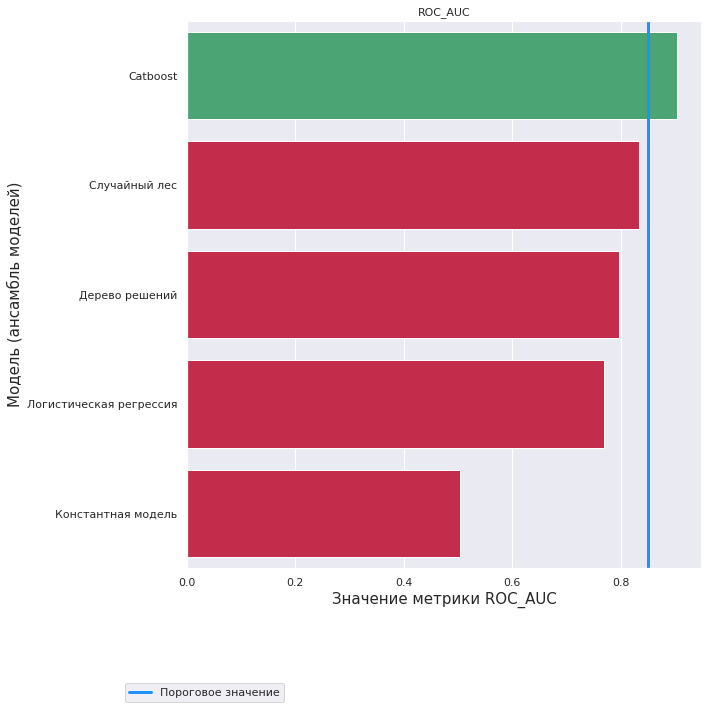

In [125]:
bar_values = summary_results['ROC_AUC']
bar_color = ['mediumseagreen' if (x > 0.85) else 'crimson' for x in bar_values]

sns.set(rc={'figure.figsize':(10, 10)})
c = sns.barplot(data = summary_results,
    x = 'ROC_AUC',
    y = 'Модель (ансамбль моделей)',
    palette = bar_color)
c.axes.set_title('ROC_AUC',fontsize=11)
c.set_xlabel('Значение метрики ROC_AUC',fontsize=15)
c.set_ylabel('Модель (ансамбль моделей)',fontsize=15)
c.tick_params(labelsize=11)
plt.axvline(0.85, linewidth = 3,
            label = 'Пороговое значение',
            color = 'dodgerblue')
plt.legend()
plt.legend(bbox_to_anchor=(0.2, -0.2), loc="best")
plt.tight_layout()
plt.show()

**1** - Мы протестировали все наши модели на кросс-валидации, а также проверили все наши гиперпарамметры, для достижения найлучших результатов

**2** - Мы протетировали 4 модели, а также построили константную модель, чтобы сравнить насколько отличаются показатели модели от константных значений

**3** - Найлучший результат показала модель CatBoost. Она единственная преодалела порог в 0.85 ROC-AUC. Осталось проверить как она покажет себя на тестовых данных.

## Часть 6. Надстройка и тестирование лучшей модели на тестовых данных

<a id='section28'></a> 
### Надстройка модели CatBoost

Одним из способов улучшить нашу модель является надстройка порога классификаций для признака 0 и 1. Давайте посмотрим как сейчас справляется наша модель

В отдельном датасете построим данные по вероятности принадлежности к классу и истенный класс в наших тестовых данных

In [126]:
matrix = pd.DataFrame(y_train)
matrix['predict'] = grid_catboost.predict(X_train)

Теперь построим матрицу ошибок

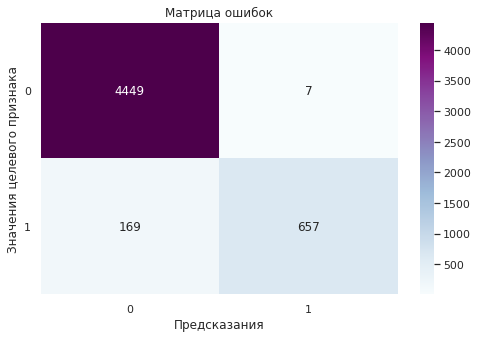

In [127]:
plt.figure(figsize = (8, 5))

confmatrix = confusion_matrix(matrix['cancelled_customer_contract'], matrix['predict'])
f = sns.heatmap(confmatrix,
                annot = True,
                cmap = 'BuPu',
                fmt = 'g')

f.set_title('Матрица ошибок')
f.set_xlabel('Предсказания')
f.set_ylabel('Значения целевого признака')
plt.yticks(rotation = 0)
plt.show()

Метрика **recall** представляет собой процент класса '1' которым модель присвоила класс '1'. Метрика показывает, насколько хорошо модель может выявить клиентов, склонных к оттоку.

Метрика **precision** показывает процент правильных значений клиентов класса '1' среди всех предсказанных моделью клиентов класса '1'. Если **recall** показывает процент правильно предсказанных '1' среди вообще всех настоящих значений '1', то **precision** показывает процент правильных '1' среди предсказанных моделью '1'.

Давайте попробуем оптимизировать эти значения и найти найлучший порог определения первого класса. Для этого нам поможет метрика **f1**

In [128]:
acc = round(accuracy_score(matrix['cancelled_customer_contract'], matrix['predict']), 3)
print('Метрика accuracy лучшей модели равна:',acc)

Метрика accuracy лучшей модели равна: 0.967


Теперь проверим различные значени порога для найлучшей метрики **f1**

In [129]:
result = []

for i in np.linspace(0, 1, 1000):
    matrix['new_predict'] = np.where(grid_catboost.predict_proba(X_train)[:, 1] >= i, 1, 0)
    confmatrix = confusion_matrix(matrix['cancelled_customer_contract'], matrix['predict'])
    f1 = f1_score(matrix['cancelled_customer_contract'], matrix['new_predict'])
    result.append((i, f1))
    
result = pd.DataFrame(result)
result.columns = ['Порог', 'F1']
best_f1 = result[result['F1'] == result['F1'].max()]
best_f1

,Порог,F1
371,0.371371,0.926554


Найлучшее значение метрики **f1** мы нашли. Теперь применим его для нашей матрицы

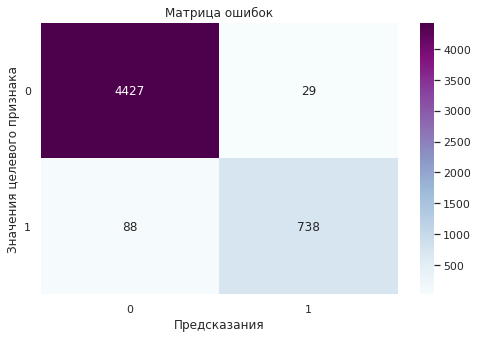

In [130]:
matrix['predict'] = np.where(grid_catboost.predict_proba(X_train)[:, 1] >= 0.371371, 1, 0)

plt.figure(figsize = (8, 5))

confmatrix = confusion_matrix(matrix['cancelled_customer_contract'], matrix['predict'])
f = sns.heatmap(confmatrix,
                annot = True,
                cmap = 'BuPu',
                fmt = 'g')

f.set_title('Матрица ошибок')
f.set_xlabel('Предсказания')
f.set_ylabel('Значения целевого признака')
plt.yticks(rotation = 0)
plt.show()

Как мы видим количество ошибок стало меньше. Давайте протестируем нашу модель при новом пороге классификации класса

In [131]:
new_catboost_model = CatBoostClassifier(random_state = RANDOM_STATE, verbose=0, iterations=500, 
                                        cat_features=cat_columns, eval_metric='AUC', learning_rate=0.1, 
                                        loss_function='Logloss')
new_catboost_model.fit(X_train, y_train, verbose=False)
new_catboost_model.set_probability_threshold(0.371371)
new_catboost_model.predict(X_train)

roc_auc_new_catboost = round(roc_auc_score(y_train, new_catboost_model.predict_proba(X_train)[:, 1]) , 3)
accuracy_new_catboost = round(accuracy_score(y_train, new_catboost_model.predict(X_train)) , 3)

print('ROC_AUC на новой модели равна:', roc_auc_new_catboost)
print('Метрика accuracy на новой модели равна:',accuracy_new_catboost*100, '%')

ROC_AUC на новой модели равна: 0.991
Метрика accuracy на новой модели равна: 97.8 %


Изменив 1 параметр мы смогли поднять нашу метрику ROC-AUC до 0.991 и повысили точность до 97,8%. Возможно этим действием мы черезчур переобучили нашу модель. Проверим это на тесте. В идеале данный порог лучше оптимизировать по множеству факторов (бюджет, стратегия компании и т.д.). Также лучше всего это делать не на тренировочной выборке, а уже для новых данных после A/B тестов, чтобы понимать нужно ли делать данную надстройку. Цель данного пробного изменения порога классификации посмотреть улучшиться ли наша модель или она переобучится и такую надстройку лучше делать позже по запросу бизнеса.

<a id='section23'></a> 
### Тестирование модели CatBoost

Одна из вещей которая может случится с моделями основанными на градиентном бустинге это ее переобучение.

Проверим как модель отработает на тестовых данных

In [132]:
roc_auc_catboost_test = round(roc_auc_score(y_test, new_catboost_model.predict_proba(X_test)[:, 1]) , 3)
accuracy_catboost_test = round(f1_score(y_test, new_catboost_model.predict(X_test)), 3)

print('ROC_AUC на тестовой выборке лучшей модели:', roc_auc_catboost_test)
print('Accuracy на тестовой выборке лучшей модели:', accuracy_catboost_test*100, '%')

ROC_AUC на тестовой выборке лучшей модели: 0.901
Accuracy на тестовой выборке лучшей модели: 67.10000000000001 %


Точность сильно упала. Мы переобучили нашу модель. Давайте проверим модель без настройки нашего порога.

In [133]:
roc_auc_catboost_test = round(roc_auc_score(y_test, grid_catboost.best_estimator_.predict_proba(X_test)[:, 1]) , 3)
acc = np.where(grid_catboost.best_estimator_.predict_proba(X_test)[:, 1] >= 0.5, 1, 0)
accuracy_catboost_test = round(accuracy_score(y_test, acc) , 3)

print('ROC_AUC на тестовой выборке лучшей модели:', roc_auc_catboost_test)
print('Accuracy на тестовой выборке лучшей модели:', accuracy_catboost_test*100, '%')

ROC_AUC на тестовой выборке лучшей модели: 0.901
Accuracy на тестовой выборке лучшей модели: 91.0 %


Как мы видим метрика похожа на тренировочную выборку. Также точность прогноза составляет 91%, что выше нашей модели, когда выставляли порог. Теперь мы знаем, что не все оптимизации стоит делать при обучении модели

<a id='section24'></a> 
### Тестирование константной модели

Давайте проверим как поведет себя наша метрика, если мы не будем использовать машинное обучение, а просто подставляли бы наши константы

In [134]:
roc_auc_dummy_test = round(roc_auc_score(y_test, grid_dummy.best_estimator_.predict_proba(X_test)[:, 1]) , 3)
acc = np.where(grid_dummy.best_estimator_.predict_proba(X_test)[:, 1] >= 0.5, 1, 0)
accuracy_dummy_test = round(accuracy_score(y_test, grid_dummy.best_estimator_.predict_proba(X_test)[:, 1]) , 3)
print('ROC_AUC на тестовой выборке константной модели:', roc_auc_dummy_test)
print('Accuracy на тестовой выборке константной модели:', accuracy_dummy_test*100, '%')
print('Разница точности между выставление константы и нашей моделью составляет',
       round((accuracy_catboost_test - accuracy_dummy_test)*100,3), '%')

ROC_AUC на тестовой выборке константной модели: 0.5
Accuracy на тестовой выборке константной модели: 73.4 %
Разница точности между выставление константы и нашей моделью составляет 17.6 %


Метрика ROC-AUC оставляет желать лучшего. Если мы посмотрим на точность, то она почти на 20% выше нашей константной модели, а это значит, что использование модели машинного обучени было оправданным решением для данной задачи

## Часть 7. Анализ важности признаков

<a id='section25'></a> 
### Анализ признаков методом SHAP

Для анализа признаков воспользуемся библиотекой SHAP

Поскольку при обучений модели CatBoost мы не кодировали категориальные признаки, то для SHAP мы это сделаем иначе мы не сможем увидеть какое значение признака влияет на увеличение вероятонсти на уход клиента 

In [135]:
pipe_final_tree['preprocessor'].fit(X_train, y_train)
scaller = pipe_final_tree.named_steps['preprocessor']
col_names = scaller.get_feature_names_out()

Теперь после кодировки признаков мы сможем понять как 1 и 0 влияют на вероятность отказа от услуг нашего абонента

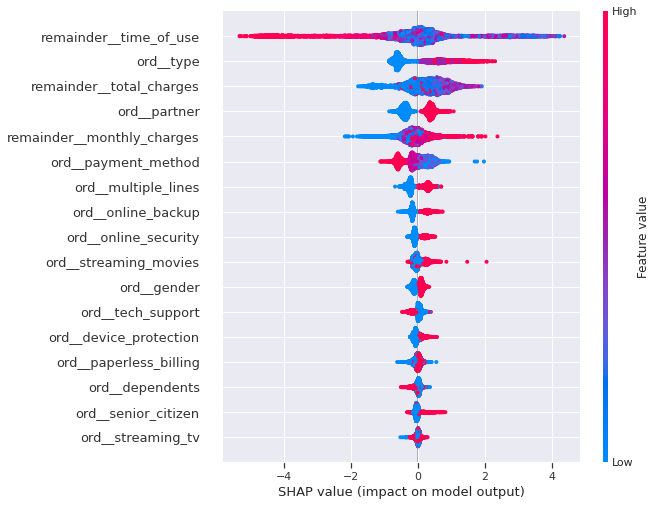

In [136]:
X_train_shap = pipe_final_tree.named_steps['preprocessor'].fit_transform(X_train)
X_test_shap = pipe_final_tree.named_steps['preprocessor'].transform(X_test)

X=X_train_shap
X=pd.DataFrame(data=X, columns=col_names)

model = CatBoostClassifier(random_state = RANDOM_STATE, verbose=False, iterations=500, 
                           learning_rate = 0.1, loss_function = 'Logloss')
model.fit(X_train_shap, y_train, verbose=False, plot=False)

explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=21)

Как видим для нашей модели самым важдным признаком является время пользования. Чем оно выше, тем меньше вероятность оттока клиента. Далее идет тип оплаты, а значит на них нужно обратить внимание. Общий платеж является производной от количества пользования и оплатой в месяц, а оплата в месяц на 5 месте по важности и чем она выше, тем больше вероятность ухода клиента. Наличие партнера, тоже является важным для оттока клиента.

<a id='section26'></a> 
### Построение матрицы ошибок на тестовых данных

В отдельном датасете построим данные по вероятности принадлежности к классу и истенный класс

In [137]:
matrix_2 = pd.DataFrame(y_test)
matrix_2['predict'] = np.where(grid_catboost.predict_proba(X_test)[:, 1] >= 0.5, 1, 0)

Теперь построим матрицу ошибок

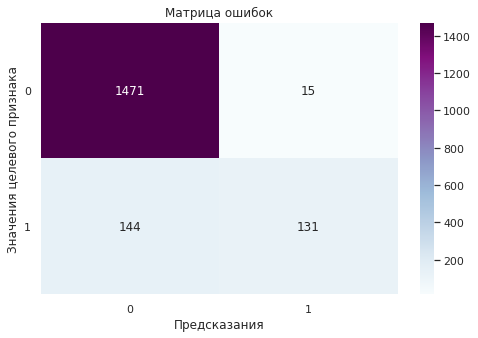

In [138]:
plt.figure(figsize = (8, 5))

confmatrix = confusion_matrix(matrix_2['cancelled_customer_contract'], matrix_2['predict'])
f = sns.heatmap(confmatrix,
                annot = True,
                cmap = 'BuPu',
                fmt = 'g')

f.set_title('Матрица ошибок')
f.set_xlabel('Предсказания')
f.set_ylabel('Значения целевого признака')
plt.yticks(rotation = 0)
plt.show()

Теперь взлянем на нашу кривую

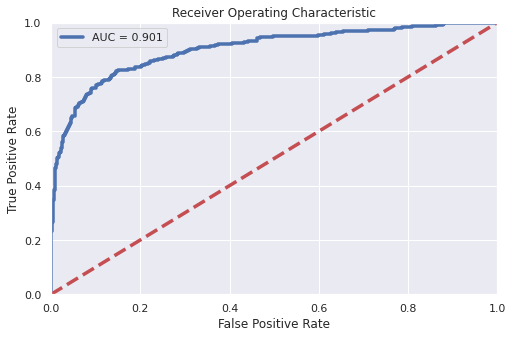

In [139]:
fprs, tprs, thrs = roc_curve(matrix_2['cancelled_customer_contract'], grid_catboost.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(matrix_2['cancelled_customer_contract'], grid_catboost.predict_proba(X_test)[:, 1])


plt.figure(figsize = (8, 5))
plt.title('Receiver Operating Characteristic')
plt.plot(fprs, tprs, 'b', label = 'AUC = %0.3f' % roc_auc, linewidth = 3.5)
plt.plot([0, 1], [0, 1],'r--', linewidth = 3.5)
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a id='section27'></a> 
### Вывод по анализам важности признаков

**1** - Оценку важности признаков мы проводили методом SHAP

**2** - Топ 3 важных признака это Время пользования, Тип оплаты и Общий платеж

## Общий вывод по проекту

В нашем распоряжении были данные компании "ТелеДом" по клиентам и подключенным услугам. Они обратились, чтобы построить модель, которая сможет на основе данных заказчика предсказать то, что абонент захочет отказаться от услуг компании.

При изучений предоставленных файлов мы не обнаружили пропусков в данных, явных и неявных дубликатов, установили ID как новый индекс в файлах, создали наш целевой признак **'cancelled_customer_contract'**, а также синтетический признак **'time_of_use'** для улучшения работы модели. Также мы привели все столбцы к нужному типу данных обработав некоторые аномалии, например пустые значения в поле **'total_charges'**

Благодаря установленным ID как индексам, мы смогли объеденить 4 файла в 1, при этом количество строк не увеличилось, а значит основаня информация в файле **contract** была доступна для каждого клиента. При объединений мы заполнили пустые строки нужной информацией.

EDA анализ наших данных показал, что:

**1** - 15,6% клиентов отказались от пользования нашими услугами

**2** - Больше половины всех пользователей оплачивают услуги каждый месяц

**3** - Мужчин и женщин, а также состоящих в браке и не женатых\не замужем распределились почти 50 на 50

**4** - Пенсионеров немного больше 15% от всех абонентов

**5** - различными доп услугами пользуются от 25% до 45% всех абонентов

**6** - Последние пол года наблюдается увеличенное количество новых абонентов

**7** - Каких либо аномалии или выбросов в датасете не было


Если расмотреть портрет отключенного абонента на основе EDA анализа, то относительно всех данных его выделяет:

**1** - Выше доля тех кто платит раз в 1-2 года, по сравнению с долей таких клиентов в данных

**2** - Большое количество состоит в Браке

**3** - Те кто пользуется доп услугами

**4** - Вероятность отключения от услуг повышается в первые 3 года пользования, далее клиенты становятся более лояльны

Также на основе мультиколлениарности были удалены 2 признака с найменьшим корреляцием между целевым

При подготовке данных к обучению мы разделили данные на тренировочную и тестовую выборку в разрезе 3 к 1. Целевой признак для модели мы закодировали через LabelEncoder. В пайплайне мы закодировали признаки через OneHotEncoder, так как у нас не было ранговых категориальных признаков, а для числовых мы использовали StandardScaler и MinMaxScaler. Для нашей задачи мы использовали линейную модель (Лосистическая регресия), деревянную модель (Дерево решении), ансамблиевую модель(Рандомный лес) и бустинг(CatBoost). Лучший результат показала бустинговая модель. Результаты оценивались по метрике ROC-AUC и она приодалела порог в 0.85. При этом без модели машинного обучения наша метрика при установке константы была 0.504.

После отбора лучшей модели мы провели ее тестирование на тестовых данных. Наша модель бустинга показала метрику 0.901. При этом по метрике точность модели она не ошибалась в 91% процентах случаев. Поскольку у нас был изначальный дисбаланс классов, то мы проверили данные, если бы просто вставили константу, то наша точность была бы в размере 73,4%, что на 17,6% меньше. Это значит, что было оправдано создание нашей модели.

Дополнительно мы провели анализ важности признаков для модели.

Для модели важными параметрами были - Время пользования, тип оплаты, а также платежи клиентов

На основании данных EDA и машинного обучения, можно дать следующие реккомендации:

**1** - Обратить внимание по пользователей в браке, так как они чаще отказываются от услуг, чем одинокие люди. Можно предложить им отдельный "семейный" тариф. Возможно так и демография повысится. Также можно продумать доп услуги для них. Например если есть дети предложить больше развлекательных каналов для детей или скидку на определенные услуги.

**2** - Время пользование тарифом. Чем дольше клиент пользуется тарифом, тем меньше шанса его ухода. Самый пик отключение наблюдается при пользованием около 1000 дней. Можно сделать прогресивную систему скидок, например для новых клентов в течении года скидка 25%, если через год клиент свяжется с оператором, то предложить скидку в 20% на год, а если через 2 года, то сделать скидку в 15% на 2 года. Таким образом можно дать возможность остаться клиентам если они захотят отказаться от тарифа из-за стоимости.

**3** - Платеж для клиента всегда будет являтся важным фактором, поэтому продумать как его снизить для клиента при этом не сильно теряя в прибыли. В качестве меры лояльности можно выбрать определенное число клиентов которые редко пользуются дополнительными услугами (если это можно отследить) и предложить их отключить снизив стоимость оплаты. Это поднимет лояльность абонентов. 

**4** - Постараться перевести как можно больше абонентов на Ежемесячную оплату, так как оплата 1-2 раза в год может сильнее разово "бить по карману", что влечет за собой отказ абонента продлевать услугу.